## EDA sur les jeux de données

In [ ]:
# importation de librairie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from scipy.stats import chi2_contingency
import os

### Agriculture Crop Yield ( les données de rendement par culture )
---

- le dataframe crop_yield à (1000000 lignes, 10 colonnes) donc 4 variables catégorielles, 2 booliènnes, 1 entier et 3 réelles. Sans valeurs manquantes
- j'observe aussi que les variables sont plutôt normale pas d'anomalie spécifique sauf:
  - Yield_to_per_hectare ( Rendement en tonnes par hectare ) valeur négative -> impossible (donc surêmment aberrantes) -> et surêmment notre variable cible

In [ ]:
crop_yield_df = pd.read_csv('../data/Agriculture Crop Yield/crop_yield.csv')
crop_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


In [ ]:
crop_yield_df.dtypes

,0
Region,object
Soil_Type,object
Crop,object
Rainfall_mm,float64
Temperature_Celsius,float64
Fertilizer_Used,bool
Irrigation_Used,bool
Weather_Condition,object
Days_to_Harvest,int64
Yield_tons_per_hectare,float64


In [ ]:
crop_yield_df.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [ ]:
# Vérification des valeurs manquant
def fill_rate(df):
    """Calcule, pour chaque colonne de df, le taux de remplissage (en pourcentage)
    et le nombre de valeurs manquantes."""
    # Pourcentage de valeurs non manquantes
    taux = df.notna().mean() * 100
    # Nombre de valeurs manquantes
    n_manquants = df.isna().sum()

    # Assemblage du résultat
    result = (
        pd.DataFrame({
            "% de remplissage": taux.round(1),
            "Nombre de NaN": n_manquants
        })
        .sort_values(by="% de remplissage", ascending=False)
    )

    return result


fill_rate(crop_yield_df)

,% de remplissage,Nombre de NaN
Region,100.0,0
Soil_Type,100.0,0
Crop,100.0,0
Rainfall_mm,100.0,0
Temperature_Celsius,100.0,0
Fertilizer_Used,100.0,0
Irrigation_Used,100.0,0
Weather_Condition,100.0,0
Days_to_Harvest,100.0,0
Yield_tons_per_hectare,100.0,0


In [ ]:
# Au niveau de l'étude des variables on va le divisé en 2 (numérique et catégorielle)
# Analyse de nos variables catégorielles
def categorical_analysis(df):
    cat_cols = df.select_dtypes(exclude=[np.number]).columns

    print("\n=== ANALYSE DES VARIABLES CATÉGORIELLES ===\n")
    for col in cat_cols:
        nb_modalites = df[col].nunique(dropna=False)
        nb_nan = df[col].isna().sum()
        taux_nan = round(nb_nan / len(df) * 100, 1)

        print(f"Variable : {col}")
        print(f"  - Modalités distinctes : {nb_modalites}")
        print(f"  - Valeurs manquantes : {nb_nan} ({taux_nan} %)")
        print("  - Fréquences des modalités :")

        # Affichage de toutes les modalités avec leur fréquence
        freq = df[col].value_counts(dropna=False)
        for modalite, count in freq.items():
            pourcentage = round(count / len(df) * 100, 1)
            print(f"      {modalite} : {count} (~ {pourcentage} %)")

        print("-" * 50)


#----------------------------------------------------------------------------------
# Analyse de nos variables numériques
def numerical_analysis(df):
    num_cols = df.select_dtypes(include=[np.number]).columns

    print("\n=== ANALYSE DES VARIABLES NUMÉRIQUES ===\n")
    for col in num_cols:
        nb_nan = df[col].isna().sum()
        taux_nan = round(nb_nan / len(df) * 100, 1)

        print(f"Variable : {col}")
        print(f"  - Valeurs manquantes : {nb_nan} ({taux_nan} %)")
        print(f"  - Min : {df[col].min()}")
        print(f"  - Max : {df[col].max()}")
        print(f"  - Moyenne : {df[col].mean():.2f}")
        print(f"  - Médiane : {df[col].median():.2f}")
        print(f"  - Écart-type : {df[col].std():.2f}")
        print("-" * 50)

#---------------------------------------------------------------------------------
# visualisation des la distribution des variables numériques
def numerical_visualisation(df, n_cols=3):
    # Sélection des colonnes numériques
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if len(num_cols) == 0:
        print("Aucune colonne numérique détectée.")
        return

    print(f"\n=== Affichage des boxplots ({len(num_cols)} variables) ===\n")

    # Calcul du nombre de lignes nécessaires
    n_rows = math.ceil(len(num_cols) / n_cols)

    # Création de la figure
    plt.figure(figsize=(n_cols * 5, n_rows * 4))

    # Boucle sur les colonnes numériques
    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x=df[col], color="skyblue")
        plt.title(col)
        plt.tight_layout()

    plt.show()


#----------------------------------------------------------------------------------
# Etude des doublons
# Verification des doublons
def duplicates_data(df, subset=None):
    # Calcul des doublons
    dup_mask = df.duplicated(subset=subset, keep=False)
    nb_dup = dup_mask.sum()

    # Différents Affichages
    if nb_dup > 0:
        if subset is None:
            print(f"Il y a {nb_dup} doublons dans les données (toutes colonnes).")
        else:
            print(f"Il y a {nb_dup} doublons dans les données (colonnes {subset}).")
        #print(df[dup_mask])
    else:
        print("Il n'y a pas de doublons dans les données.")

#----------------------------------------------------------------------------------
# etude des outliers
def detect_outliers(df, thresh = 1.5):
    # Sélection des colonnes numériques
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) == 0:
        print("Aucune colonne numérique détectée.")
        return None
    print(f"\n=== Détection des valeurs aberrantes (méthode IQR) avec un seuil({thresh}) ===\n")

    outlier_info = {}
    outlier_mask = pd.DataFrame(False, index=df.index, columns=num_cols)
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - thresh * IQR
        upper_bound = Q3 + thresh * IQR

        mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_mask[col] = mask

        outlier_info[col] = {
            "nb_outliers": mask.sum(),
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        }
    # Résumé lisible
    summary = pd.DataFrame(outlier_info).T
    print(summary)
    # Extraction des lignes contenant au moins un outlier
    df_outliers = df[outlier_mask.any(axis=1)]
    print(f"\nNombre total de lignes contenant au moins un outlier : {df_outliers.shape[0]}")
    return df_outliers

In [ ]:
# commençons par les variables numérique
numerical_analysis(crop_yield_df)


=== ANALYSE DES VARIABLES NUMÉRIQUES ===

Variable : Rainfall_mm
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 100.00089622522204
  - Max : 999.998098221668
  - Moyenne : 549.98
  - Médiane : 550.12
  - Écart-type : 259.85
--------------------------------------------------
Variable : Temperature_Celsius
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 15.000034141430271
  - Max : 39.99999662316004
  - Moyenne : 27.50
  - Médiane : 27.51
  - Écart-type : 7.22
--------------------------------------------------
Variable : Days_to_Harvest
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 60
  - Max : 149
  - Moyenne : 104.50
  - Médiane : 104.00
  - Écart-type : 25.95
--------------------------------------------------
Variable : Yield_tons_per_hectare
  - Valeurs manquantes : 0 (0.0 %)
  - Min : -1.147613222534901
  - Max : 9.963372228814649
  - Moyenne : 4.65
  - Médiane : 4.65
  - Écart-type : 1.70
--------------------------------------------------


In [ ]:
# continuons par nos variables catégorielle
categorical_analysis(crop_yield_df)


=== ANALYSE DES VARIABLES CATÉGORIELLES ===

Variable : Region
  - Modalités distinctes : 4
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      North : 250173 (~ 25.0 %)
      West : 250074 (~ 25.0 %)
      South : 250054 (~ 25.0 %)
      East : 249699 (~ 25.0 %)
--------------------------------------------------
Variable : Soil_Type
  - Modalités distinctes : 6
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      Sandy : 167119 (~ 16.7 %)
      Loam : 166795 (~ 16.7 %)
      Chalky : 166779 (~ 16.7 %)
      Silt : 166672 (~ 16.7 %)
      Clay : 166352 (~ 16.6 %)
      Peaty : 166283 (~ 16.6 %)
--------------------------------------------------
Variable : Crop
  - Modalités distinctes : 6
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      Maize : 166824 (~ 16.7 %)
      Rice : 166792 (~ 16.7 %)
      Barley : 166777 (~ 16.7 %)
      Wheat : 166673 (~ 16.7 %)
      Cotton : 166585 (~ 16.7 %)
      Soybean : 166349 (~ 16.6 %)
-


=== Affichage des boxplots (4 variables) ===



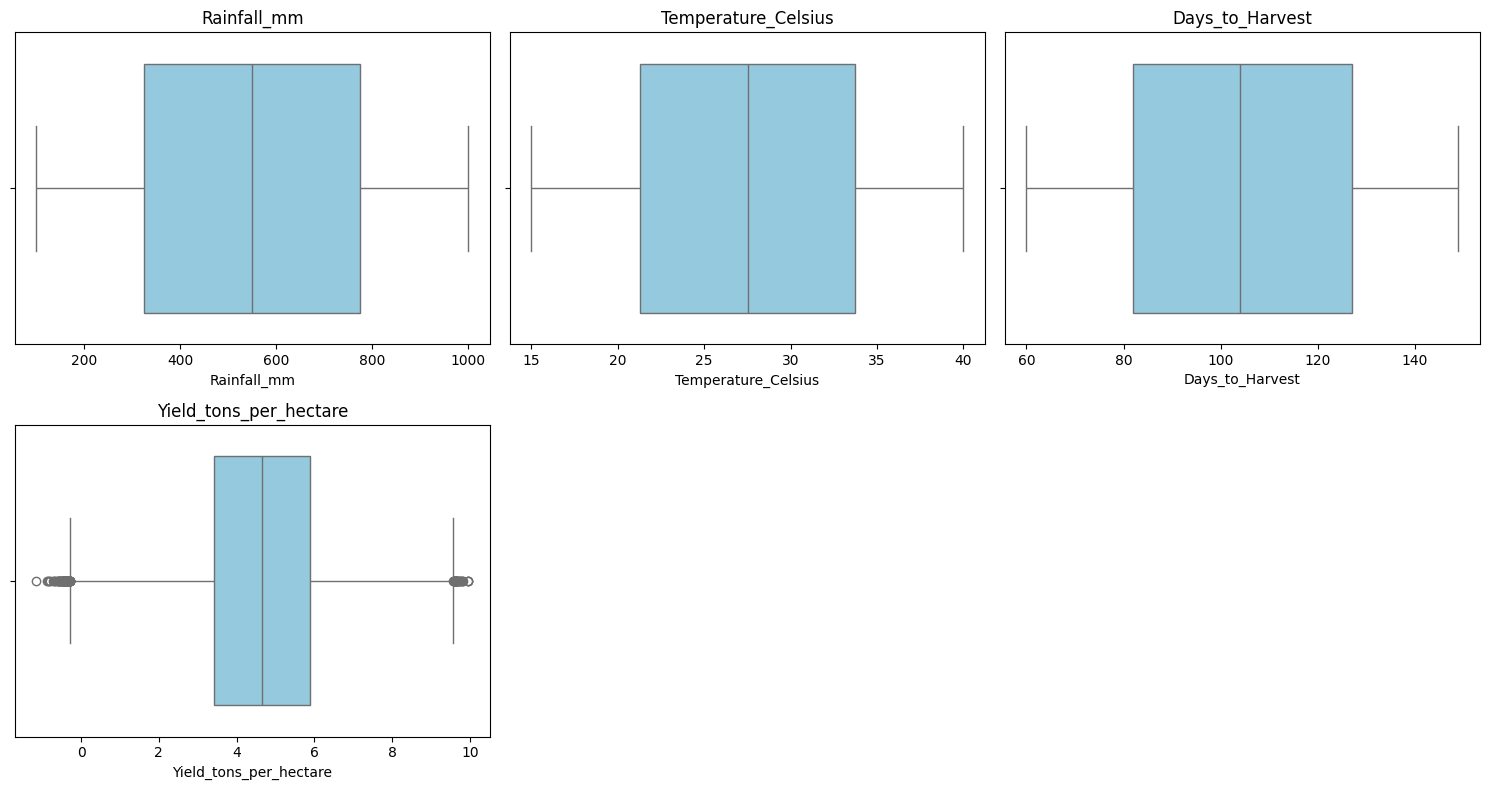

In [ ]:
numerical_visualisation(crop_yield_df)

In [ ]:
# Nous obsevons sur le graphique précedent qu'il y'a la présences des outlier (<0 et >9 de Yield_to_per_hectare)
out_crop_yield = detect_outliers(crop_yield_df)


=== Détection des valeurs aberrantes (méthode IQR) avec un seuil(1.5) ===

                        nb_outliers  lower_bound  upper_bound
Rainfall_mm                     0.0  -349.880055  1449.509665
Temperature_Celsius             0.0     2.506355    52.501415
Days_to_Harvest                 0.0    14.500000   194.500000
Yield_tons_per_hectare         84.0    -0.274707     9.571544

Nombre total de lignes contenant au moins un outlier : 84


In [ ]:
#Donc toutes les valeurs < –0.27 ou > 9.57 sont considérées comme aberrantes. (Yield_tons_per_hectare)
out_crop_yield.sample(5)

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
465022,East,Sandy,Wheat,978.875813,35.301038,True,True,Rainy,143,9.802534
942403,South,Silt,Maize,987.281001,23.821032,True,True,Rainy,114,9.826285
130676,South,Silt,Maize,127.758149,28.539525,False,False,Rainy,130,-0.335048
363782,West,Peaty,Barley,102.037727,20.427482,False,False,Rainy,123,-0.645920
773387,North,Clay,Wheat,174.906657,16.581441,False,False,Sunny,128,-1.147613


In [ ]:
out_crop_yield[out_crop_yield['Yield_tons_per_hectare'] < 0]

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
39669,East,Loam,Barley,147.755191,20.390486,False,False,Cloudy,72,-0.469229
54745,North,Peaty,Barley,119.136310,15.984143,False,False,Cloudy,93,-0.290180
77504,West,Sandy,Wheat,120.422223,22.809881,False,False,Rainy,120,-0.841617
93760,West,Clay,Soybean,108.811480,17.936402,False,False,Rainy,88,-0.434482
107852,East,Silt,Maize,151.735877,15.868006,False,False,Rainy,135,-0.559459
117051,North,Clay,Cotton,109.900182,32.504570,False,False,Sunny,148,-0.482681
119918,South,Loam,Rice,189.125534,21.979907,False,False,Cloudy,143,-0.293918
130676,South,Silt,Maize,127.758149,28.539525,False,False,Rainy,130,-0.335048
133956,South,Peaty,Rice,125.438324,20.037363,False,False,Sunny,100,-0.345716
143664,West,Chalky,Cotton,127.476723,26.541013,False,False,Rainy,99,-0.416235


In [ ]:
out_crop_yield[out_crop_yield['Yield_tons_per_hectare'] > 9.57]

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
11596,West,Peaty,Wheat,957.380991,36.324216,True,True,Sunny,73,9.727004
173732,South,Clay,Rice,998.991449,22.513905,True,True,Cloudy,68,9.613384
224117,West,Silt,Barley,954.911259,34.653132,True,True,Rainy,146,9.580166
230072,North,Loam,Cotton,956.623791,39.830278,True,True,Cloudy,149,9.647672
288994,East,Loam,Wheat,965.464197,34.606854,True,True,Rainy,124,9.668197
350006,West,Loam,Barley,910.598704,38.842505,True,True,Cloudy,135,9.580710
385993,East,Clay,Rice,977.530313,30.647480,True,True,Rainy,137,9.721110
401635,West,Peaty,Wheat,937.648660,39.507361,True,True,Rainy,61,9.685660
461357,West,Clay,Barley,996.078325,36.972621,True,True,Rainy,135,9.595395
465022,East,Sandy,Wheat,978.875813,35.301038,True,True,Rainy,143,9.802534


* Les valeurs négatives sont impossible, mais nous observons que ceux positive sont être un tout petit peu extrême mais très probablement possible :
* engrais + irrigation = rendement élevé  & pas d’engrais + pas d’irrigation = rendement faible

In [ ]:
# c'est prétendus outliers sont des erreur dans la génération du dataset (mais de toute façon je vais les supprimé car même pas 1% de mon dataset)
crop_yield_df = crop_yield_df[crop_yield_df['Yield_tons_per_hectare'].between(-0.27,9.57)]

In [ ]:
# Vérifions si y'a des doublons ou pas
duplicates_data(crop_yield_df)

Il n'y a pas de doublons dans les données.


In [ ]:
# Etude de redondance
# commençons par nos variables numériques
def correlation_graph(data, corr_type):
  num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
  if len(num_cols) == 0:
        print("Aucune colonne numérique détectée.")
        exit()
  corr = data[num_cols].corr(method=corr_type)

  # On trace les heatmaps
  plt.figure(figsize=(12, 6))
  sns.heatmap(corr,annot=True,fmt='.2f',linewidths=0.5,cmap='coolwarm',cbar_kws={'shrink': 0.75})
  plt.title(f"Matrice de corrélation des variables numériques ({corr_type})")
  plt.show()

#------------------------------------------------------------------------------------------
# ensuite nos variables catégorielles
def chi2_study(data):
    # Sélection des colonnes catégorielles
    cat_cols = data.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    print("\n=== Analyse Chi² des variables catégorielles ===\n")

    for var1, var2 in itertools.combinations(cat_cols, 2):
        table = pd.crosstab(data[var1], data[var2])
        # Si le tableau est trop petit ou vide, on skip
        if table.shape[0] < 2 or table.shape[1] < 2:
            continue
        chi2, p, dof, _ = chi2_contingency(table)
        print(f"{var1} vs {var2}")
        print(f"Chi2 = {chi2:.2f}, ddl = {dof}, p-value = {p:.6f}")

        if p < 0.05:
            print("Forte dépendance entre les deux")
        else:
            print("Variables indépendantes (pas de redondance évidente)")
        print("-" * 60)


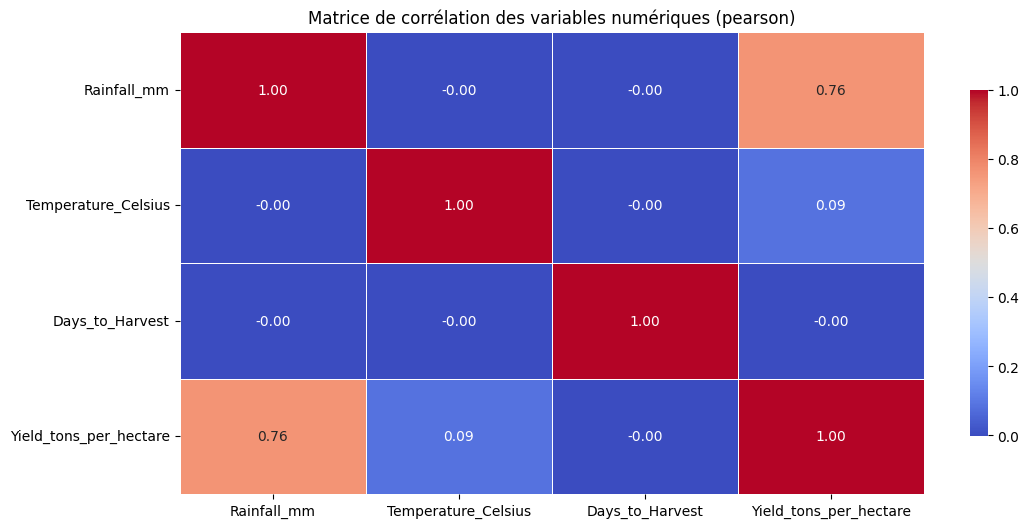

In [ ]:
correlation_graph(crop_yield_df, 'pearson')

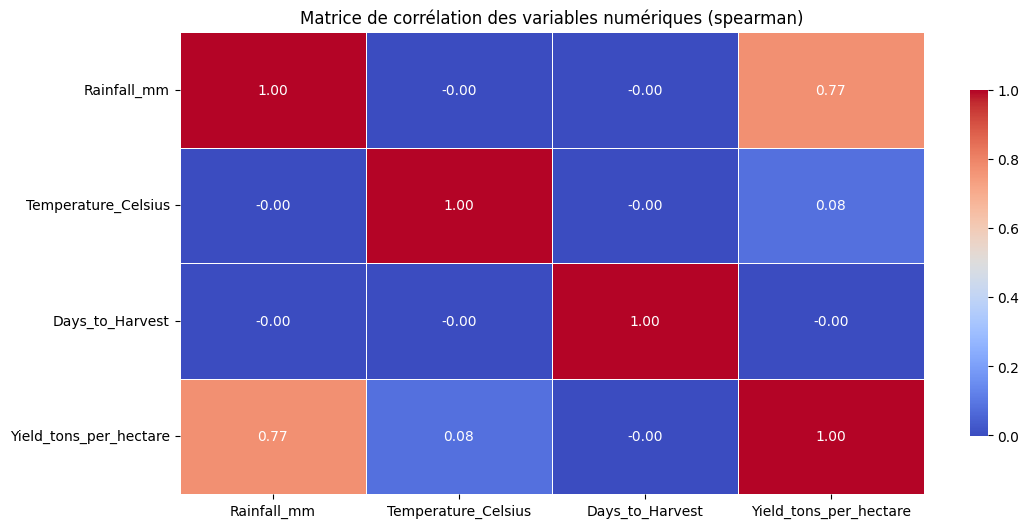

In [ ]:
correlation_graph(crop_yield_df, 'spearman')

* Plus il pleut, plus le rendement augmente, de manière régulière et stable.

In [ ]:
chi2_study(crop_yield_df)


=== Analyse Chi² des variables catégorielles ===

Region vs Soil_Type
Chi2 = 14.48, ddl = 15, p-value = 0.489636
Variables indépendantes (pas de redondance évidente)
------------------------------------------------------------
Region vs Crop
Chi2 = 21.36, ddl = 15, p-value = 0.125621
Variables indépendantes (pas de redondance évidente)
------------------------------------------------------------
Region vs Fertilizer_Used
Chi2 = 0.67, ddl = 3, p-value = 0.880825
Variables indépendantes (pas de redondance évidente)
------------------------------------------------------------
Region vs Irrigation_Used
Chi2 = 0.77, ddl = 3, p-value = 0.855980
Variables indépendantes (pas de redondance évidente)
------------------------------------------------------------
Region vs Weather_Condition
Chi2 = 5.22, ddl = 6, p-value = 0.516384
Variables indépendantes (pas de redondance évidente)
------------------------------------------------------------
Soil_Type vs Crop
Chi2 = 20.08, ddl = 25, p-value = 0.7

* Aucune variable catégorielle n’est dépendante d’une autre.

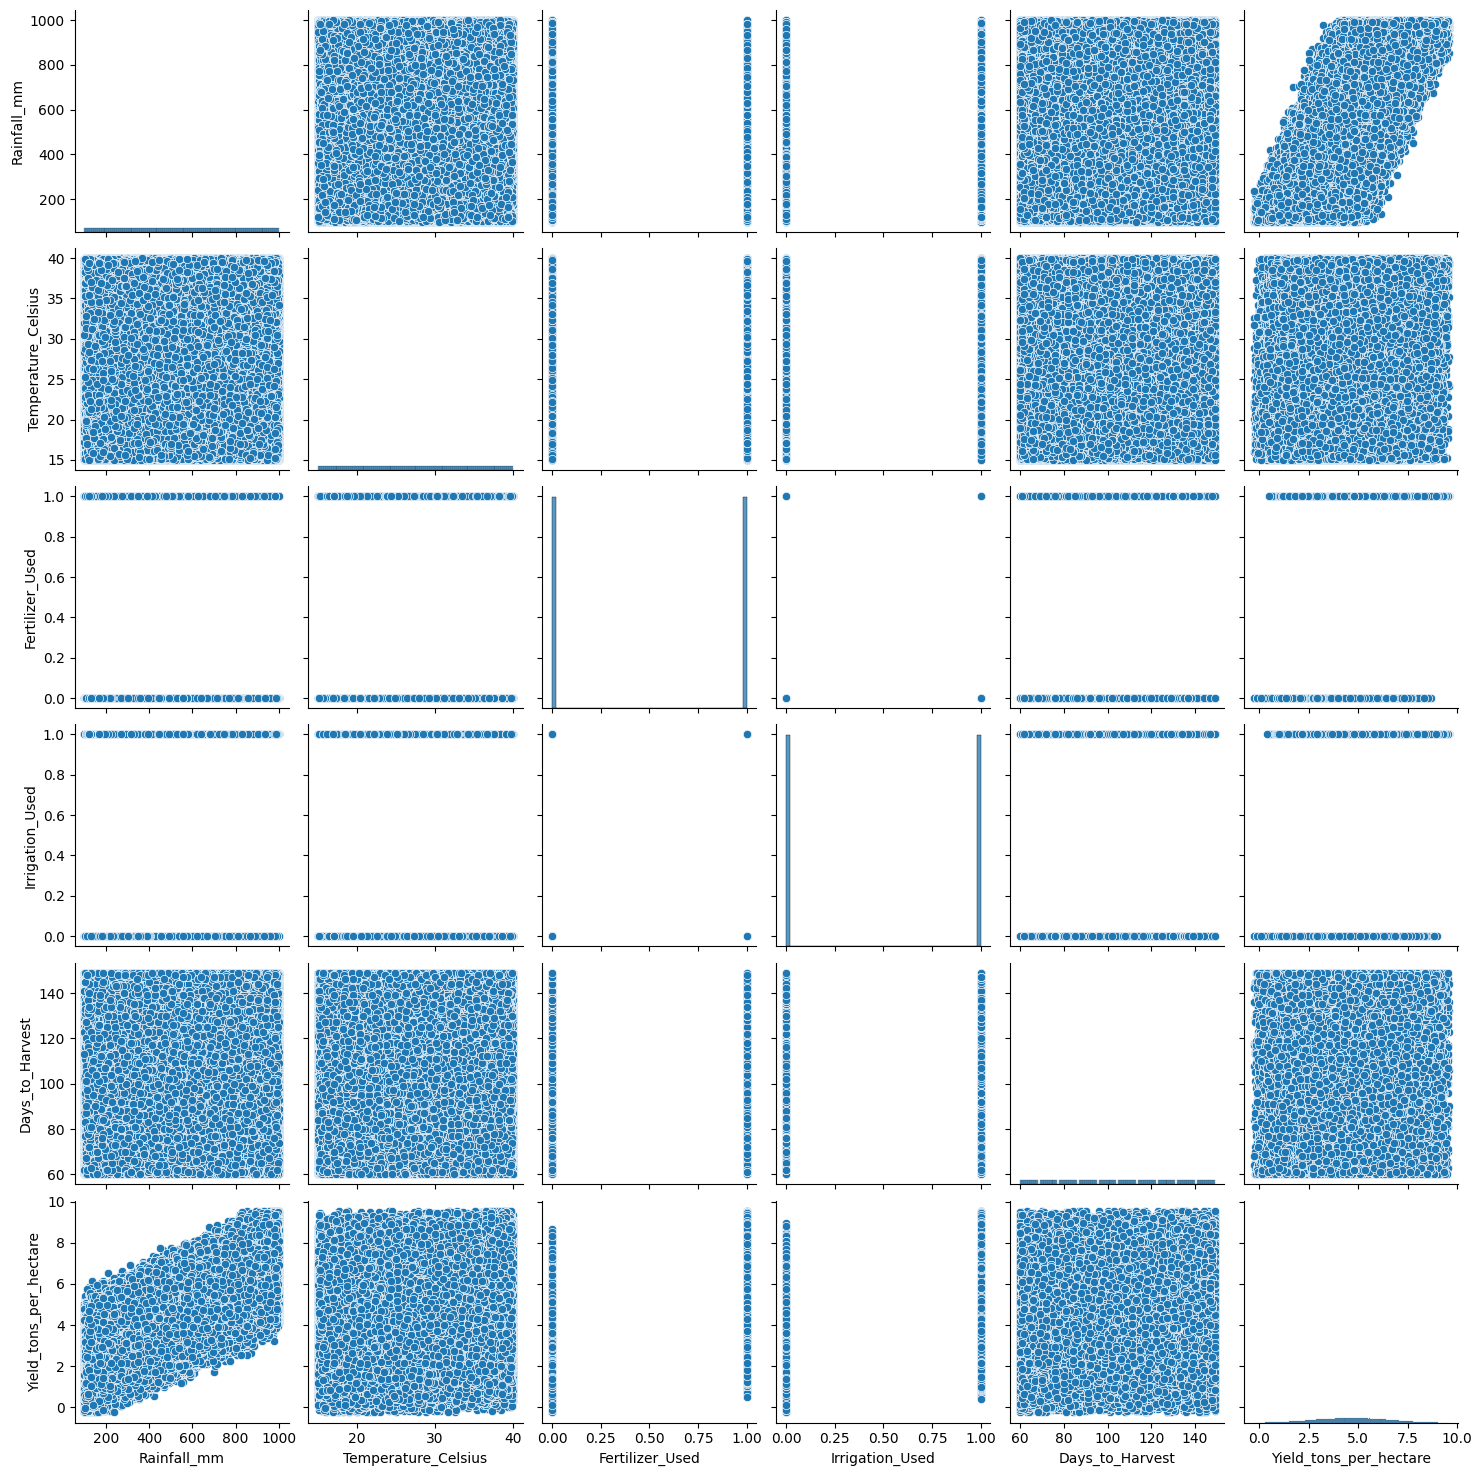

In [ ]:
sns.pairplot(crop_yield_df)
plt.show();

### Crop Yield Prediction Dataset (facteurs agronomiques et climatiques plus généraux)

In [ ]:
pesticides_df = pd.read_csv('../data/Crop Yield Prediction Dataset/pesticides.csv')
rainfall_df = pd.read_csv('../data/Crop Yield Prediction Dataset/rainfall.csv')
temp_df = pd.read_csv('../data/Crop Yield Prediction Dataset/temp.csv')
yield_df_1 = pd.read_csv('../data/Crop Yield Prediction Dataset/yield.csv')
yield_df_2 = pd.read_csv('../data/Crop Yield Prediction Dataset/yield_df.csv')

#### Pesticides

---

- 4349 lignes, 7 colonnes, aucun NaN.
- 4 colonnes avec une seule modalité (à Supprimer):
  - Domain -> "Pesticides Use"
  - Element -> "Use"
  - Item -> "Pesticides (total)"
  - Unit -> "tonnes of active ingredients"
- Area -> 168 pays
- Year -> 1990 à 2016

In [ ]:
pesticides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4349 entries, 0 to 4348
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Domain   4349 non-null   object 
 1   Area     4349 non-null   object 
 2   Element  4349 non-null   object 
 3   Item     4349 non-null   object 
 4   Year     4349 non-null   int64  
 5   Unit     4349 non-null   object 
 6   Value    4349 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 238.0+ KB


In [ ]:
pesticides_df.shape

(4349, 7)

In [ ]:
pesticides_df.sample(5)

,Domain,Area,Element,Item,Year,Unit,Value
2199,Pesticides Use,Lao People's Democratic Republic,Use,Pesticides (total),1998,tonnes of active ingredients,0.66
23,Pesticides Use,Albania,Use,Pesticides (total),2013,tonnes of active ingredients,982.32
3515,Pesticides Use,Slovakia,Use,Pesticides (total),2014,tonnes of active ingredients,1721.83
1925,Pesticides Use,Ireland,Use,Pesticides (total),1990,tonnes of active ingredients,2014.00
1117,Pesticides Use,Croatia,Use,Pesticides (total),2008,tonnes of active ingredients,2388.00


In [ ]:
fill_rate(pesticides_df)

,% de remplissage,Nombre de NaN
Domain,100.0,0
Area,100.0,0
Element,100.0,0
Item,100.0,0
Year,100.0,0
Unit,100.0,0
Value,100.0,0


In [ ]:
numerical_analysis(pesticides_df)


=== ANALYSE DES VARIABLES NUMÉRIQUES ===

Variable : Year
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 1990
  - Max : 2016
  - Moyenne : 2003.14
  - Médiane : 2003.00
  - Écart-type : 7.73
--------------------------------------------------
Variable : Value
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 0.0
  - Max : 1807000.0
  - Moyenne : 20303.34
  - Médiane : 1137.56
  - Écart-type : 117736.19
--------------------------------------------------


In [ ]:
categorical_analysis(pesticides_df)


=== ANALYSE DES VARIABLES CATÉGORIELLES ===

Variable : Domain
  - Modalités distinctes : 1
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      Pesticides Use : 4349 (~ 100.0 %)
--------------------------------------------------
Variable : Area
  - Modalités distinctes : 168
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      Albania : 27 (~ 0.6 %)
      Algeria : 27 (~ 0.6 %)
      Angola : 27 (~ 0.6 %)
      Antigua and Barbuda : 27 (~ 0.6 %)
      Argentina : 27 (~ 0.6 %)
      Australia : 27 (~ 0.6 %)
      Austria : 27 (~ 0.6 %)
      Bahamas : 27 (~ 0.6 %)
      China, Hong Kong SAR : 27 (~ 0.6 %)
      Bahrain : 27 (~ 0.6 %)
      Bangladesh : 27 (~ 0.6 %)
      Barbados : 27 (~ 0.6 %)
      Bolivia (Plurinational State of) : 27 (~ 0.6 %)
      Bhutan : 27 (~ 0.6 %)
      Bermuda : 27 (~ 0.6 %)
      Belize : 27 (~ 0.6 %)
      Botswana : 27 (~ 0.6 %)
      Brazil : 27 (~ 0.6 %)
      Brunei Darussalam : 27 (~ 0.6 %)
      Bulgaria : 27 (


=== Affichage des boxplots (2 variables) ===



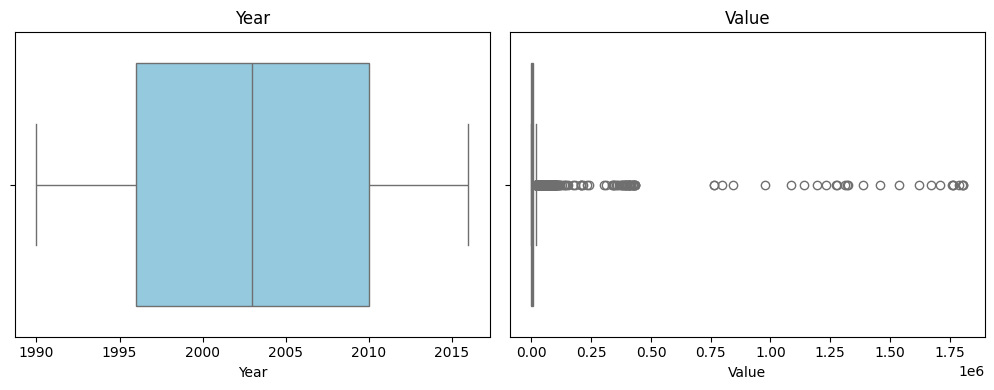

In [ ]:
numerical_visualisation(pesticides_df)

In [ ]:
out_pesticides = detect_outliers(pesticides_df, thresh=2)


=== Détection des valeurs aberrantes (méthode IQR) avec un seuil(2) ===

       nb_outliers  lower_bound  upper_bound
Year           0.0       1968.0       2038.0
Value        564.0     -15459.0      23421.0

Nombre total de lignes contenant au moins un outlier : 564


In [ ]:
out_pesticides.sample(5)

,Domain,Area,Element,Item,Year,Unit,Value
3596,Pesticides Use,Spain,Use,Pesticides (total),2016,tonnes of active ingredients,61895.00
2446,Pesticides Use,Malaysia,Use,Pesticides (total),2016,tonnes of active ingredients,49199.43
3985,Pesticides Use,Turkey,Use,Pesticides (total),2004,tonnes of active ingredients,28831.00
887,Pesticides Use,"China, mainland",Use,Pesticides (total),1992,tonnes of active ingredients,799174.00
536,Pesticides Use,Brazil,Use,Pesticides (total),1992,tonnes of active ingredients,67003.89


In [ ]:
out_pesticides['Area'].unique()

array(['Argentina', 'Australia', 'Bolivia (Plurinational State of)',
       'Brazil', 'Canada', 'China, mainland', 'Colombia', 'Costa Rica',
       'Ecuador', 'France', 'Germany', 'India', 'Italy', 'Japan',
       'Malaysia', 'Mexico', 'Pakistan', 'Paraguay', 'Peru', 'Poland',
       'Republic of Korea', 'Romania', 'Russian Federation',
       'South Africa', 'Spain', 'Thailand', 'Turkey', 'Ukraine',
       'United Kingdom', 'United States of America', 'Uruguay', 'USSR',
       'Viet Nam'], dtype=object)

* Nous avons 564 (13% de nos données) valeurs extrême mais je pense que c'est normal:
  - comme c'est en fonction des pays et que les pays n'ont pas une consommation équivalent (d'autres pays en consomment plus que d'autres)
  - Dans nos données on a la France Chine, Etats-Unis, l'Inde, Brésil... Des pays qui utilisent beaucoup de pesticides que les autre pays (ex: aficains)
  -  ce sont en réalité les pays les plus importants du dataset.
  - Solution pour ces valeur extrêmes : nous avons une distribution extrêmement asymétriques donc nous allons appliqué une log-transformation (qui réduit l'effet des valeurs extrême, distribution plus normale)


In [ ]:
# tranformation log
pesticides_df['Value_log'] = np.log1p(pesticides_df['Value'])

In [ ]:
cols_todorp = ["Domain","Element","Item","Unit", 'Value']
pesticides_df.drop(columns=cols_todorp, inplace=True)


=== Affichage des boxplots (2 variables) ===



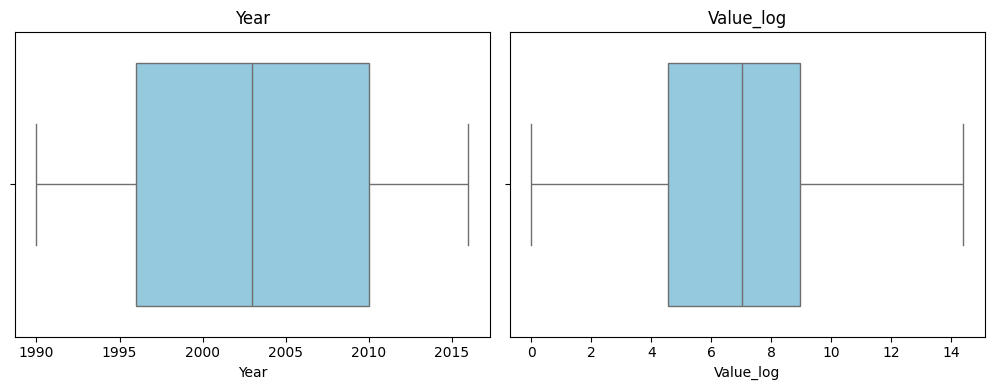

In [ ]:
numerical_visualisation(pesticides_df)

In [ ]:
# les doublons (colonnes percipales année et pays)
duplicates_data(pesticides_df, ['Area', 'Year'])

Il n'y a pas de doublons dans les données.


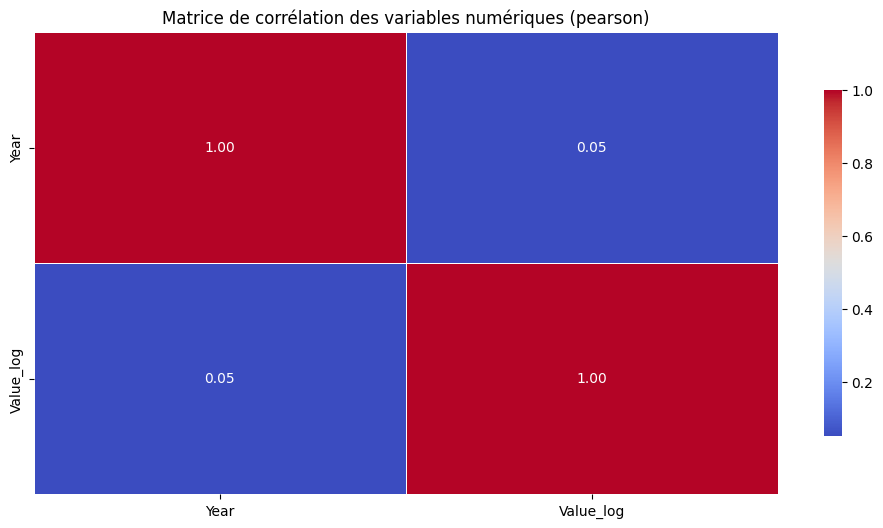

In [ ]:
correlation_graph(pesticides_df, 'pearson')

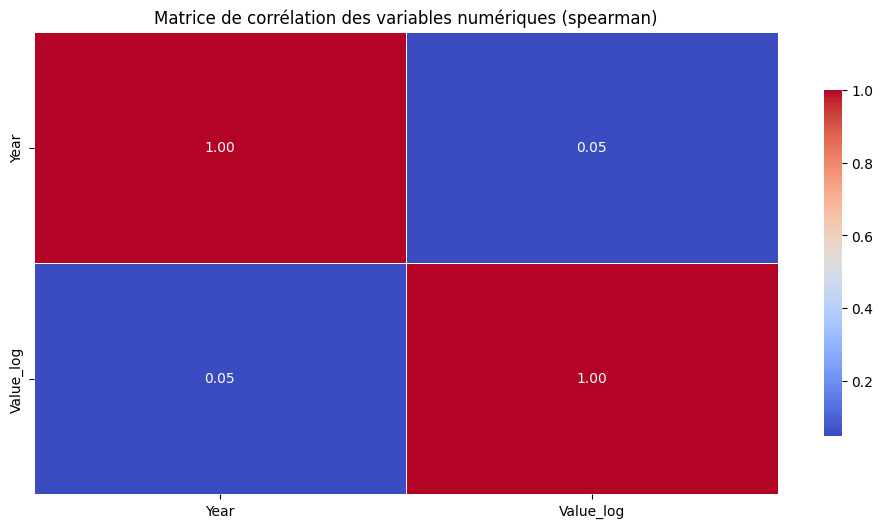

In [ ]:
correlation_graph(pesticides_df, 'spearman')

In [ ]:
pesticides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4349 entries, 0 to 4348
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       4349 non-null   object 
 1   Year       4349 non-null   int64  
 2   Value_log  4349 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 102.1+ KB


#### Rainfall

---

- 6727 lignes, 3 colonnes, 774 (~11,5%) NaN.
- average_rain_fall_mm_per_year -> valeurs manquantes + mauvais type
- après l'étude des NaN les area sont pas des pays agricole majeurs
- ce sont des territoire trop petit et Elles n’ont aucune donnée de pluie (Dons on vas les supprimée

In [ ]:
rainfall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0    Area                          6727 non-null   object
 1   Year                           6727 non-null   int64 
 2   average_rain_fall_mm_per_year  5953 non-null   object
dtypes: int64(1), object(2)
memory usage: 157.8+ KB


In [ ]:
rainfall_df.sample(5)

,Area,Year,average_rain_fall_mm_per_year
4670,Palau,2007,494
1972,Eswatini,2006,788
3335,Kyrgyz Republic,2005,533
6447,Uruguay,2017,1300
3412,Lebanon,1987,661


In [ ]:
fill_rate(rainfall_df)

,% de remplissage,Nombre de NaN
Area,100.0,0
Year,100.0,0
average_rain_fall_mm_per_year,88.5,774


In [ ]:
# convertissons déjà en valeur numerique
rainfall_df['average_rain_fall_mm_per_year'] = pd.to_numeric(rainfall_df["average_rain_fall_mm_per_year"], errors='coerce')

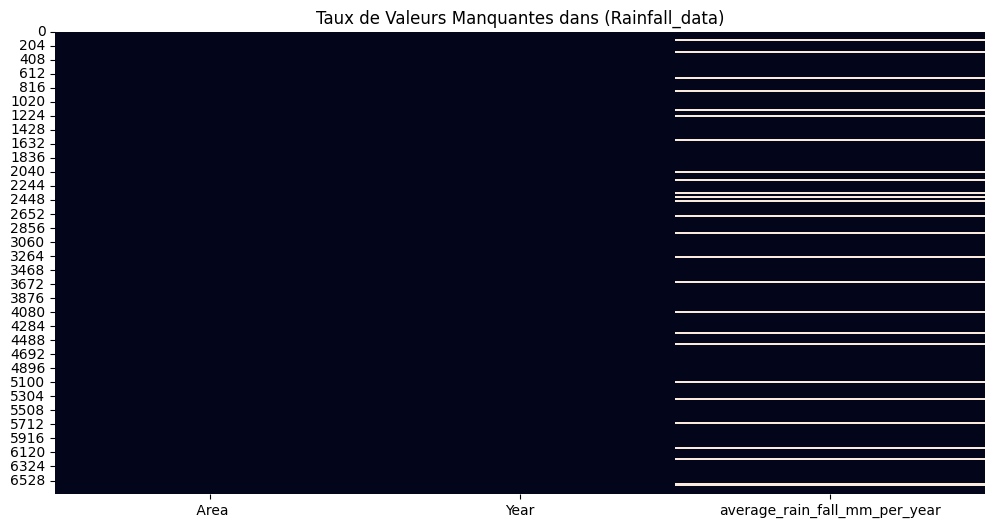

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(rainfall_df.isna(), cbar=False)
plt.title('Taux de Valeurs Manquantes dans (Rainfall_data)')
plt.show()

In [ ]:
fill_rate(rainfall_df)

,% de remplissage,Nombre de NaN
Area,100.0,0
Year,100.0,0
average_rain_fall_mm_per_year,88.4,780


In [ ]:
# vérifions quel pays manquent le plus de valeurs manquantes
is_null_df = rainfall_df[rainfall_df['average_rain_fall_mm_per_year'].isna() == True]

In [ ]:
# quels pays manquent le plus
is_null_df[' Area'].value_counts()

,count
Area,
American Samoa,31
Aruba,31
Bermuda,31
British Virgin Islands,31
Cayman Islands,31
Channel Islands,31
Faroe Islands,31
Curacao,31
French Polynesia,31


In [ ]:
# Quelles années manquent les plus
is_null_df.Year.value_counts()

,count
Year,
1985,26
1986,26
1989,26
1991,26
1990,26
1987,25
1992,25
1993,25
1994,25


In [ ]:
# analysons toutes les données avant de décisé quoi faire des NaN
numerical_analysis(rainfall_df)


=== ANALYSE DES VARIABLES NUMÉRIQUES ===

Variable : Year
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 1985
  - Max : 2017
  - Moyenne : 2001.35
  - Médiane : 2001.00
  - Écart-type : 9.53
--------------------------------------------------
Variable : average_rain_fall_mm_per_year
  - Valeurs manquantes : 780 (11.6 %)
  - Min : 51.0
  - Max : 3240.0
  - Moyenne : 1124.74
  - Médiane : 1010.00
  - Écart-type : 786.26
--------------------------------------------------


In [ ]:
categorical_analysis(rainfall_df)


=== ANALYSE DES VARIABLES CATÉGORIELLES ===

Variable :  Area
  - Modalités distinctes : 217
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      Afghanistan : 31 (~ 0.5 %)
      Albania : 31 (~ 0.5 %)
      Algeria : 31 (~ 0.5 %)
      American Samoa : 31 (~ 0.5 %)
      Andorra : 31 (~ 0.5 %)
      Angola : 31 (~ 0.5 %)
      Antigua and Barbuda : 31 (~ 0.5 %)
      Argentina : 31 (~ 0.5 %)
      Armenia : 31 (~ 0.5 %)
      Aruba : 31 (~ 0.5 %)
      Australia : 31 (~ 0.5 %)
      Austria : 31 (~ 0.5 %)
      Azerbaijan : 31 (~ 0.5 %)
      Bahamas : 31 (~ 0.5 %)
      Bahrain : 31 (~ 0.5 %)
      Bangladesh : 31 (~ 0.5 %)
      Barbados : 31 (~ 0.5 %)
      Belarus : 31 (~ 0.5 %)
      Belgium : 31 (~ 0.5 %)
      Belize : 31 (~ 0.5 %)
      Benin : 31 (~ 0.5 %)
      Bermuda : 31 (~ 0.5 %)
      Bhutan : 31 (~ 0.5 %)
      Bolivia : 31 (~ 0.5 %)
      Bosnia and Herzegovina : 31 (~ 0.5 %)
      Botswana : 31 (~ 0.5 %)
      Brazil : 31 (~ 0.5 %)
      British V


=== Affichage des boxplots (2 variables) ===



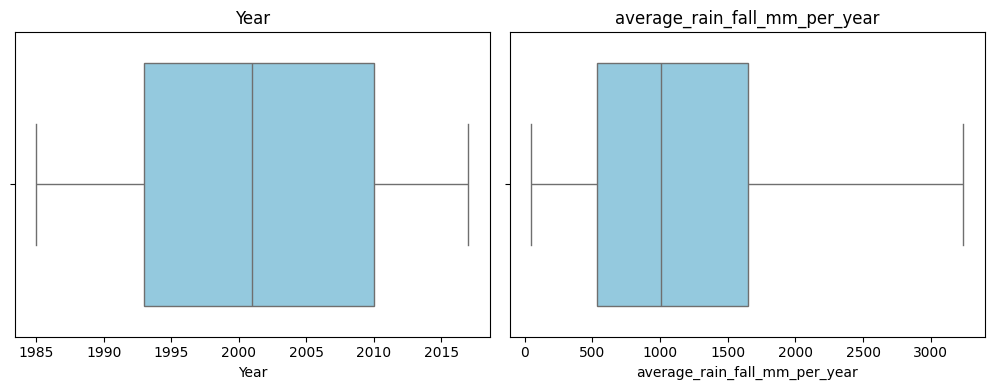

In [ ]:
numerical_visualisation(rainfall_df)

In [ ]:
# après ces analyses nous pouvons supprimé les pays ou 100% de NaN
to_drop = rainfall_df.groupby(' Area')["average_rain_fall_mm_per_year"].apply(lambda x: x.isna().all())
cont_todrop = to_drop[to_drop].index.tolist()
cont_todrop

['American Samoa',
 'Aruba',
 'Bermuda',
 'British Virgin Islands',
 'Cayman Islands',
 'Channel Islands',
 'Curacao',
 'Faroe Islands',
 'French Polynesia',
 'Gibraltar',
 'Greenland',
 'Guam',
 'Hong Kong SAR, China',
 'Isle of Man',
 'Kosovo',
 'Macao SAR, China',
 'Monaco',
 'New Caledonia',
 'Northern Mariana Islands',
 'San Marino',
 'Sint Maarten (Dutch part)',
 'St. Martin (French part)',
 'Tonga',
 'Turks and Caicos Islands',
 'Virgin Islands (U.S.)']

In [ ]:
rainfall_df = rainfall_df[~rainfall_df[' Area'].isin(cont_todrop)]
fill_rate(rainfall_df)

,% de remplissage,Nombre de NaN
Area,100.0,0
Year,100.0,0
average_rain_fall_mm_per_year,99.9,5


In [ ]:
# les pays restant nous allons imputé par moyenne par pays (ici je pense que les 5 restant sont les bahamas)
rainfall_df["average_rain_fall_mm_per_year"] = (
    rainfall_df.groupby(" Area")["average_rain_fall_mm_per_year"]
    .transform(lambda x: x.fillna(x.mean()))
)
fill_rate(rainfall_df)

,% de remplissage,Nombre de NaN
Area,100.0,0
Year,100.0,0
average_rain_fall_mm_per_year,100.0,0


In [ ]:
detect_outliers(rainfall_df)


=== Détection des valeurs aberrantes (méthode IQR) avec un seuil(1.5) ===

                               nb_outliers  lower_bound  upper_bound
Year                                   0.0      1967.50      2035.50
average_rain_fall_mm_per_year          0.0     -1137.75      3324.25

Nombre total de lignes contenant au moins un outlier : 0


,Area,Year,average_rain_fall_mm_per_year


In [ ]:
duplicates_data(rainfall_df, subset=[' Area', 'Year'])

Il n'y a pas de doublons dans les données.


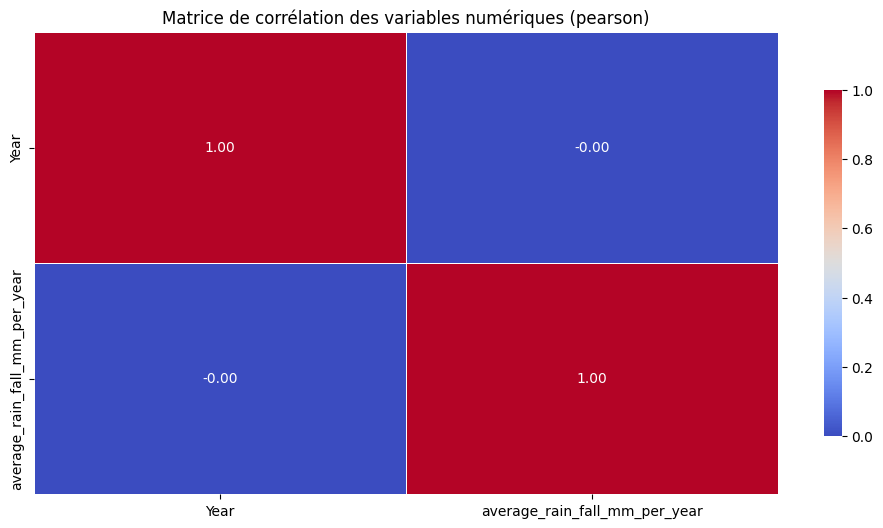

In [ ]:
correlation_graph(rainfall_df, 'pearson')

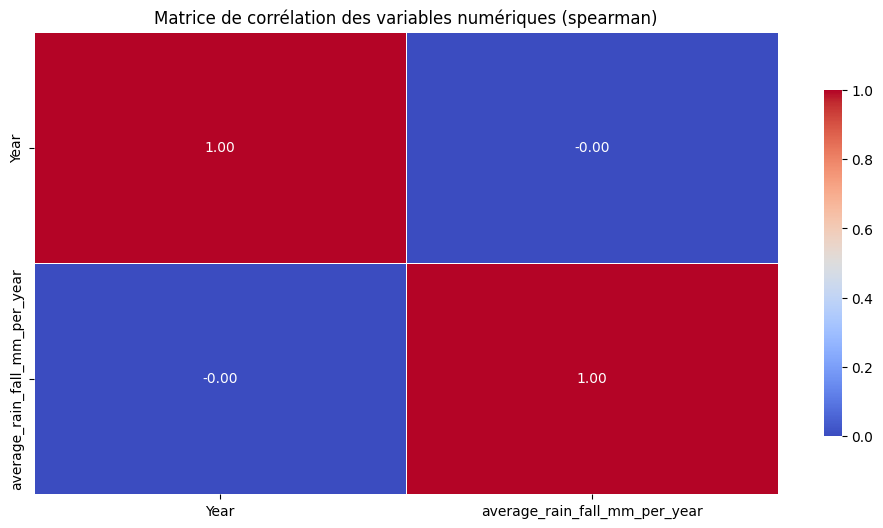

In [ ]:
correlation_graph(rainfall_df, 'spearman')

In [ ]:
rainfall_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5952 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0    Area                          5952 non-null   object 
 1   Year                           5952 non-null   int64  
 2   average_rain_fall_mm_per_year  5952 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 186.0+ KB


#### Temperature

---

- 71311 lignes, 3 colonnes, 2547 (~3.6%) NaN.

In [ ]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71311 entries, 0 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      71311 non-null  int64  
 1   country   71311 non-null  object 
 2   avg_temp  68764 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [ ]:
temp_df.sample(5)

,year,country,avg_temp
47643,1854,United States,10.96
22008,1989,United States,16.07
12116,1987,Hungary,9.58
28445,1805,India,25.54
49148,1800,France,10.46


In [ ]:
fill_rate(temp_df)

,% de remplissage,Nombre de NaN
year,100.0,0
country,100.0,0
avg_temp,96.4,2547


In [ ]:
numerical_analysis(temp_df)


=== ANALYSE DES VARIABLES NUMÉRIQUES ===

Variable : year
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 1743
  - Max : 2013
  - Moyenne : 1905.80
  - Médiane : 1910.00
  - Écart-type : 67.10
--------------------------------------------------
Variable : avg_temp
  - Valeurs manquantes : 2547 (3.6 %)
  - Min : -14.35
  - Max : 30.73
  - Moyenne : 16.18
  - Médiane : 16.14
  - Écart-type : 7.59
--------------------------------------------------



=== Affichage des boxplots (2 variables) ===



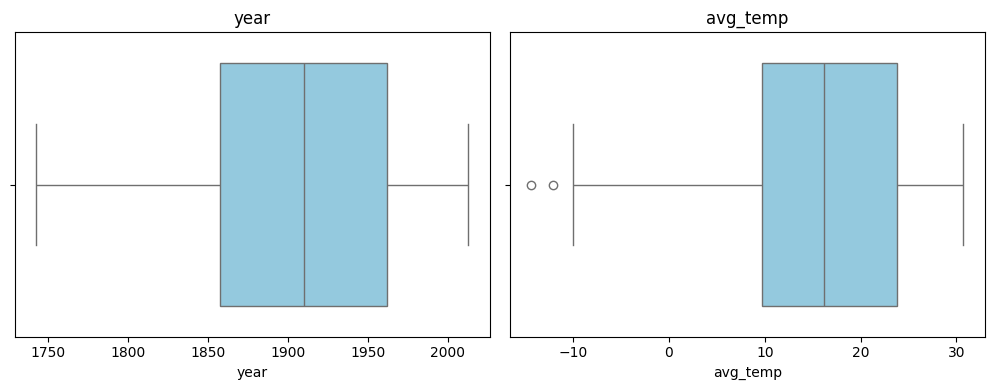

In [ ]:
numerical_visualisation(temp_df)

In [ ]:
categorical_analysis(temp_df)


=== ANALYSE DES VARIABLES CATÉGORIELLES ===

Variable : country
  - Modalités distinctes : 137
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      United States : 11973 (~ 16.8 %)
      China : 6172 (~ 8.7 %)
      India : 4756 (~ 6.7 %)
      Russia : 2257 (~ 3.2 %)
      Brazil : 1997 (~ 2.8 %)
      Pakistan : 1805 (~ 2.5 %)
      Canada : 1541 (~ 2.2 %)
      Mexico : 1394 (~ 2.0 %)
      United Kingdom : 1355 (~ 1.9 %)
      Turkey : 1285 (~ 1.8 %)
      Indonesia : 1134 (~ 1.6 %)
      Nigeria : 1113 (~ 1.6 %)
      Japan : 1030 (~ 1.4 %)
      Australia : 1027 (~ 1.4 %)
      Venezuela : 950 (~ 1.3 %)
      Spain : 813 (~ 1.1 %)
      Germany : 813 (~ 1.1 %)
      South Africa : 628 (~ 0.9 %)
      Iran : 560 (~ 0.8 %)
      Serbia : 542 (~ 0.8 %)
      Italy : 542 (~ 0.8 %)
      Libya : 522 (~ 0.7 %)
      Taiwan : 519 (~ 0.7 %)
      Morocco : 512 (~ 0.7 %)
      Philippines : 505 (~ 0.7 %)
      Ecuador : 445 (~ 0.6 %)
      Bangladesh : 436 (~ 0.6 %)
  

In [ ]:
detect_outliers(temp_df)


=== Détection des valeurs aberrantes (méthode IQR) avec un seuil(1.5) ===

          nb_outliers  lower_bound  upper_bound
year              0.0   1702.00000   2118.00000
avg_temp          2.0    -11.26875     44.78125

Nombre total de lignes contenant au moins un outlier : 2


,year,country,avg_temp
4416,1815,Kazakhstan,-12.13
47806,1815,Russia,-14.35


* D'après mes recherches : 1815 C’est l’année de l’éruption du Tambora, qui a provoqué -> “l’année sans été” (1816), un refroidissement global, des anomalies climatiques massives. Donc ces valeurs ont un sens historique. Ce ne sont pas des erreurs. Ce sont des valeurs extrêmes mais scientifiquement cohérentes.

In [ ]:
# Avant de décidé quoi faire des NaN nous allons faire quelques analyses
na_df = temp_df[temp_df['avg_temp'].isna() == True]

In [ ]:
na_df['country'].value_counts()
# Nous observons qu'il y'a beaucoups de pays important sur cette liste

,count
country,
United States,381
India,236
Pakistan,168
Indonesia,167
Brazil,115
...,...
Japan,2
Honduras,2
Iran,1


In [ ]:
na_df['year'].value_counts()

,count
year,
1747,79
1748,79
1746,79
1749,79
1863,69
...,...
1769,2
1820,2
1752,2


* Conclusion sur les NaN :
- Les NaN sont concentrés dans les années très anciennes (ils diminuent progressivement à mesure qu'on avance dans le temps
- En croissant les années et pays -> beaucoup de pays n'existait pas avant 1900 et beaucoups de pays n'avaient pas de station météo avant 1850

In [ ]:
# reconstruisons les années manquantes entre deux valeurs connues
temp_df['avg_temp'] = temp_df.groupby('country')['avg_temp'].transform(lambda x: x.interpolate(methode='linear'))
# imputation des extémités par moyenne du pays
temp_df['avg_temp'] = temp_df.groupby('country')['avg_temp'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
fill_rate(temp_df)

,% de remplissage,Nombre de NaN
year,100.0,0
country,100.0,0
avg_temp,100.0,0


In [ ]:
# chaque pays à une température par année
duplicates_data(temp_df, subset=['country', 'year'])

Il y a 50791 doublons dans les données (colonnes ['country', 'year']).


In [ ]:
temp_df[temp_df.duplicated(subset=['country', 'year'], keep=False)].head(10)

,year,country,avg_temp
0,1849,Côte D'Ivoire,25.580
1,1850,Côte D'Ivoire,25.520
2,1851,Côte D'Ivoire,25.670
3,1852,Côte D'Ivoire,25.792
4,1853,Côte D'Ivoire,25.914
5,1854,Côte D'Ivoire,26.036
6,1855,Côte D'Ivoire,26.158
7,1856,Côte D'Ivoire,26.280
8,1857,Côte D'Ivoire,25.170
9,1858,Côte D'Ivoire,25.490


In [ ]:
# Nous allons resoudre le problème de doublons en faisant la moyenne par pays et par année
temp_df = temp_df.groupby(['country', 'year'], as_index=False).agg({'avg_temp': 'mean'})

In [ ]:
duplicates_data(temp_df, subset=['country', 'year'])

Il n'y a pas de doublons dans les données.


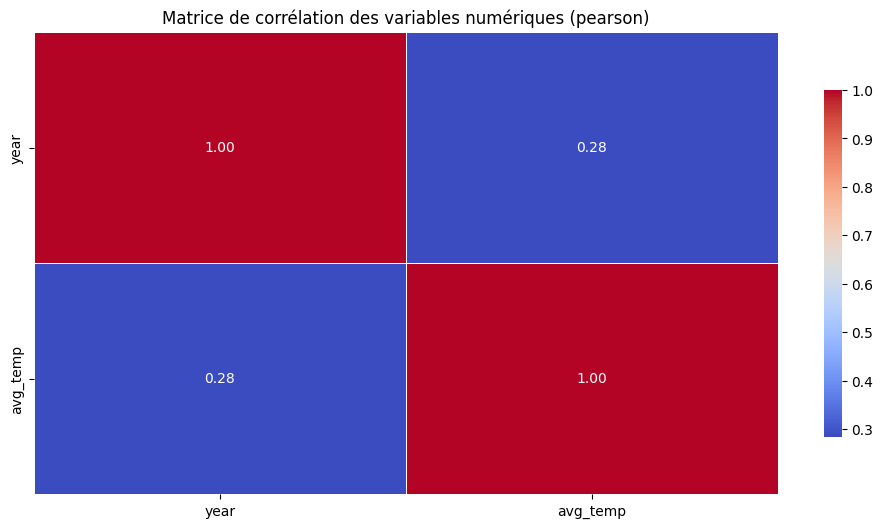

In [ ]:
correlation_graph(temp_df, 'pearson')

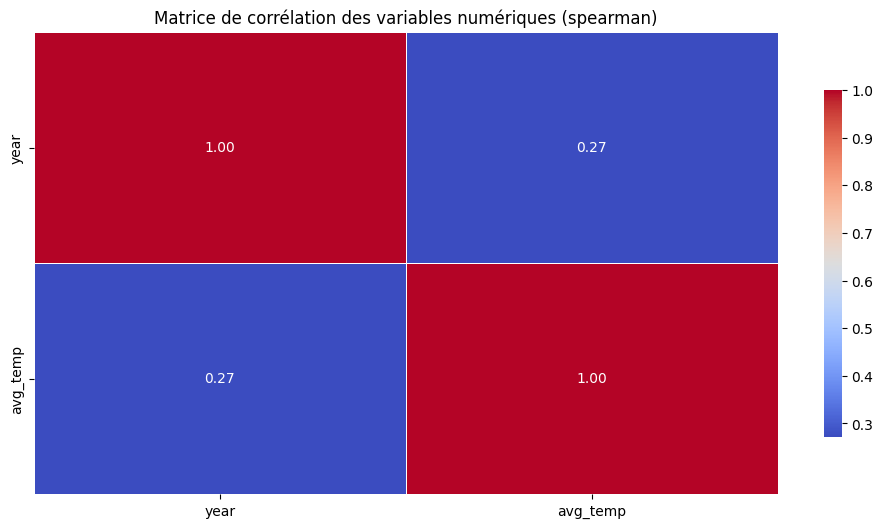

In [ ]:
correlation_graph(temp_df, 'spearman')

#### Yield 1

---

- 56717 lignes, 12 colonnes, 0 NaN.
- Colonnes à Supprimer :
  - Domain Code
  - Domain
  - Element Code
  - Element
  - Unit
  - Year Code
  - Area Code (optionnel)
  - Item Code (optionnel)

In [ ]:
yield_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Domain Code   56717 non-null  object
 1   Domain        56717 non-null  object
 2   Area Code     56717 non-null  int64 
 3   Area          56717 non-null  object
 4   Element Code  56717 non-null  int64 
 5   Element       56717 non-null  object
 6   Item Code     56717 non-null  int64 
 7   Item          56717 non-null  object
 8   Year Code     56717 non-null  int64 
 9   Year          56717 non-null  int64 
 10  Unit          56717 non-null  object
 11  Value         56717 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 5.2+ MB


In [ ]:
yield_df_1.sample(5)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
1039,QC,Crops,7,Angola,5419,Yield,116,Potatoes,2003,2003,hg/ha,45212
21477,QC,Crops,87,Guadeloupe,5419,Yield,125,Cassava,1983,1983,hg/ha,90000
5712,QC,Crops,21,Brazil,5419,Yield,56,Maize,1996,1996,hg/ha,24761
20229,QC,Crops,73,Georgia,5419,Yield,116,Potatoes,2013,2013,hg/ha,114517
8187,QC,Crops,32,Cameroon,5419,Yield,489,Plantains and others,2011,2011,hg/ha,110857


In [ ]:
fill_rate(yield_df_1)

,% de remplissage,Nombre de NaN
Domain Code,100.0,0
Domain,100.0,0
Area Code,100.0,0
Area,100.0,0
Element Code,100.0,0
Element,100.0,0
Item Code,100.0,0
Item,100.0,0
Year Code,100.0,0
Year,100.0,0


In [ ]:
numerical_analysis(yield_df_1)


=== ANALYSE DES VARIABLES NUMÉRIQUES ===

Variable : Area Code
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 1
  - Max : 351
  - Moyenne : 125.65
  - Médiane : 122.00
  - Écart-type : 75.12
--------------------------------------------------
Variable : Element Code
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 5419
  - Max : 5419
  - Moyenne : 5419.00
  - Médiane : 5419.00
  - Écart-type : 0.00
--------------------------------------------------
Variable : Item Code
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 15
  - Max : 489
  - Moyenne : 111.61
  - Médiane : 116.00
  - Écart-type : 101.28
--------------------------------------------------
Variable : Year Code
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 1961
  - Max : 2016
  - Moyenne : 1989.67
  - Médiane : 1991.00
  - Écart-type : 16.13
--------------------------------------------------
Variable : Year
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 1961
  - Max : 2016
  - Moyenne : 1989.67
  - Médiane : 1991.00
  - Écart-type : 16.13
-


=== Affichage des boxplots (6 variables) ===



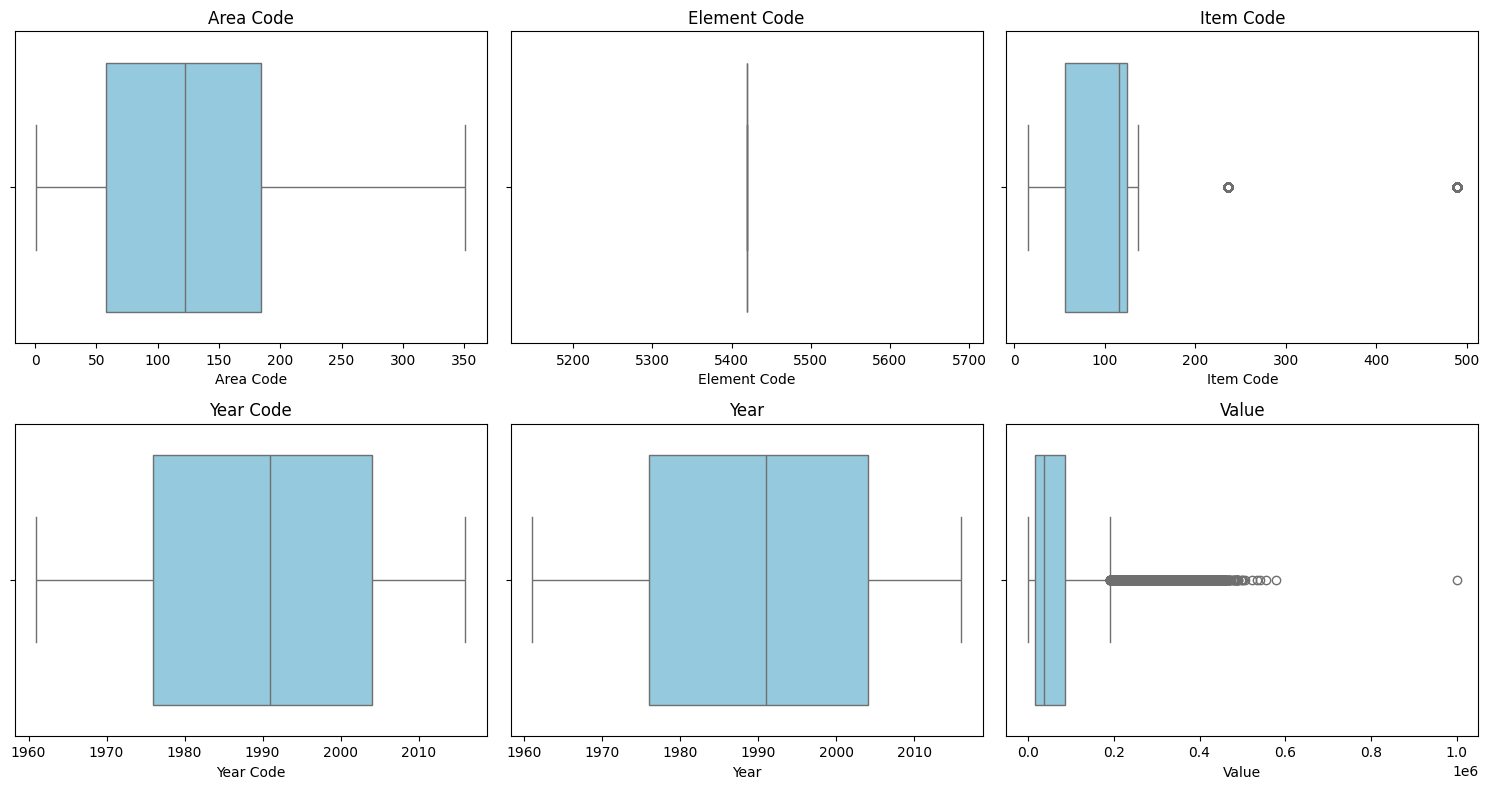

In [ ]:
numerical_visualisation(yield_df_1)

In [ ]:
categorical_analysis(yield_df_1)


=== ANALYSE DES VARIABLES CATÉGORIELLES ===

Variable : Domain Code
  - Modalités distinctes : 1
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      QC : 56717 (~ 100.0 %)
--------------------------------------------------
Variable : Domain
  - Modalités distinctes : 1
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      Crops : 56717 (~ 100.0 %)
--------------------------------------------------
Variable : Area
  - Modalités distinctes : 212
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      Democratic Republic of the Congo : 560 (~ 1.0 %)
      Nigeria : 560 (~ 1.0 %)
      United Republic of Tanzania : 560 (~ 1.0 %)
      Venezuela (Bolivarian Republic of) : 532 (~ 0.9 %)
      Cameroon : 528 (~ 0.9 %)
      Rwanda : 522 (~ 0.9 %)
      Brazil : 504 (~ 0.9 %)
      Peru : 504 (~ 0.9 %)
      Colombia : 504 (~ 0.9 %)
      Burundi : 504 (~ 0.9 %)
      Kenya : 503 (~ 0.9 %)
      Uganda : 499 (~ 0.9 %)
      Ecuador : 489 (

In [ ]:
var_to_drop = [
    "Domain Code", "Domain",
    "Element Code", "Element",
    "Unit", "Year Code", "Area Code", "Item Code"]

In [ ]:
out_df = detect_outliers(yield_df_1.drop(columns=var_to_drop)) # car une variables pas importantes


=== Détection des valeurs aberrantes (méthode IQR) avec un seuil(1.5) ===

       nb_outliers  lower_bound  upper_bound
Year           0.0       1934.0       2046.0
Value       3169.0     -90119.5     192012.5

Nombre total de lignes contenant au moins un outlier : 3169


In [ ]:
out_df.sample(5)

,Area,Item,Year,Value
36054,New Zealand,Potatoes,1984,298653
25910,Ireland,Potatoes,1996,301646
20931,Greece,Potatoes,2003,206661
32678,Mauritius,Potatoes,2003,210187
48826,Sweden,Potatoes,1983,232619


In [ ]:
# les pays les plus presents dans nos valeurs extêmes
out_df['Area'].value_counts()

,count
Area,
Japan,135
Israel,113
Cook Islands,93
Egypt,84
United States of America,70
...,...
Bolivia (Plurinational State of),1
Papua New Guinea,1
Mozambique,1


In [ ]:
# les culture présentes dans ces outliers
out_df.Item.value_counts()

,count
Item,
Potatoes,2058
Sweet potatoes,575
Cassava,247
Plantains and others,166
Maize,62
Yams,52
Sorghum,9


* Les pays sont les plus industrialisés et avec les meilleurs technologies agricoles et probablemment les rendements les plus élevés du monde
* Les types de cultures aussi son très productives donc ce sont des valeurs normales

In [ ]:
# Nous allons corrigé la distribution avec du log-transformation
yield_df_1["Value_log"] = np.log1p(yield_df_1["Value"])
var_to_drop.append('Value')

In [ ]:
duplicates_data(yield_df_1.drop(columns=var_to_drop), ['Area', 'Item', 'Year'])

Il n'y a pas de doublons dans les données.


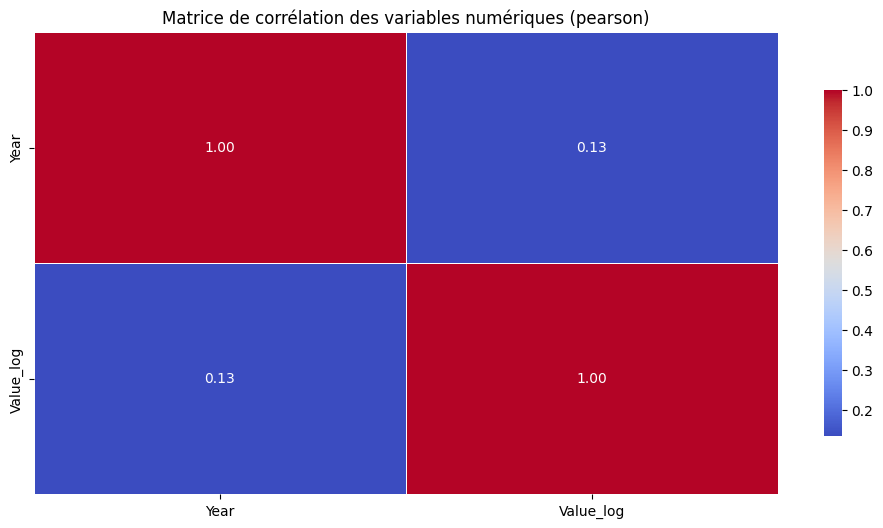

In [ ]:
correlation_graph(yield_df_1.drop(columns=var_to_drop), 'pearson')

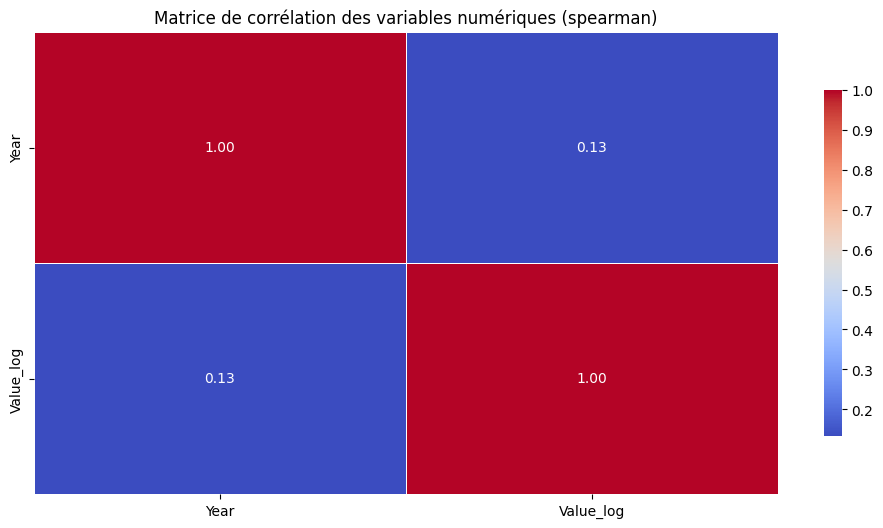

In [ ]:
correlation_graph(yield_df_1.drop(columns=var_to_drop), 'spearman')

In [ ]:
chi2_study(yield_df_1.drop(columns=var_to_drop))


=== Analyse Chi² des variables catégorielles ===

Area vs Item
Chi2 = 43094.18, ddl = 1899, p-value = 0.000000
Forte dépendance entre les deux
------------------------------------------------------------


In [ ]:
print(var_to_drop)

['Domain Code', 'Domain', 'Element Code', 'Element', 'Unit', 'Year Code', 'Area Code', 'Item Code', 'Value']


In [ ]:
yield_df_1.drop(columns=var_to_drop, inplace=True)

In [ ]:
yield_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       56717 non-null  object 
 1   Item       56717 non-null  object 
 2   Year       56717 non-null  int64  
 3   Value_log  56717 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.7+ MB


* Les cultures ne sont pas distribuées au hasard entre les pays.

#### Yield 2

---

- 28242 lignes, 8 colonnes, 0 NaN.

In [ ]:
yield_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB


In [ ]:
yield_df_2.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
yield_df_2.sample(5)

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
3113,Brazil,Sweet potatoes,1995,110676,1761.0,92967.22,25.65
17972,Libya,Maize,2010,19333,56.0,3548.00,21.17
21229,New Zealand,Potatoes,1992,327179,1732.0,3490.00,12.14
27424,Ukraine,Potatoes,2004,133386,565.0,15344.40,8.32
27204,Uganda,Cassava,1996,67015,1180.0,88.00,23.49


In [ ]:
fill_rate(yield_df_2)

,% de remplissage,Nombre de NaN
Area,100.0,0
Item,100.0,0
Year,100.0,0
hg/ha_yield,100.0,0
average_rain_fall_mm_per_year,100.0,0
pesticides_tonnes,100.0,0
avg_temp,100.0,0


In [ ]:
numerical_analysis(yield_df_2)


=== ANALYSE DES VARIABLES NUMÉRIQUES ===

Variable : Year
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 1990
  - Max : 2013
  - Moyenne : 2001.54
  - Médiane : 2001.00
  - Écart-type : 7.05
--------------------------------------------------
Variable : hg/ha_yield
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 50
  - Max : 501412
  - Moyenne : 77053.33
  - Médiane : 38295.00
  - Écart-type : 84956.61
--------------------------------------------------
Variable : average_rain_fall_mm_per_year
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 51.0
  - Max : 3240.0
  - Moyenne : 1149.06
  - Médiane : 1083.00
  - Écart-type : 709.81
--------------------------------------------------
Variable : pesticides_tonnes
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 0.04
  - Max : 367778.0
  - Moyenne : 37076.91
  - Médiane : 17529.44
  - Écart-type : 59958.78
--------------------------------------------------
Variable : avg_temp
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 1.3
  - Max : 30.65
  - Moyenne : 2


=== Affichage des boxplots (5 variables) ===



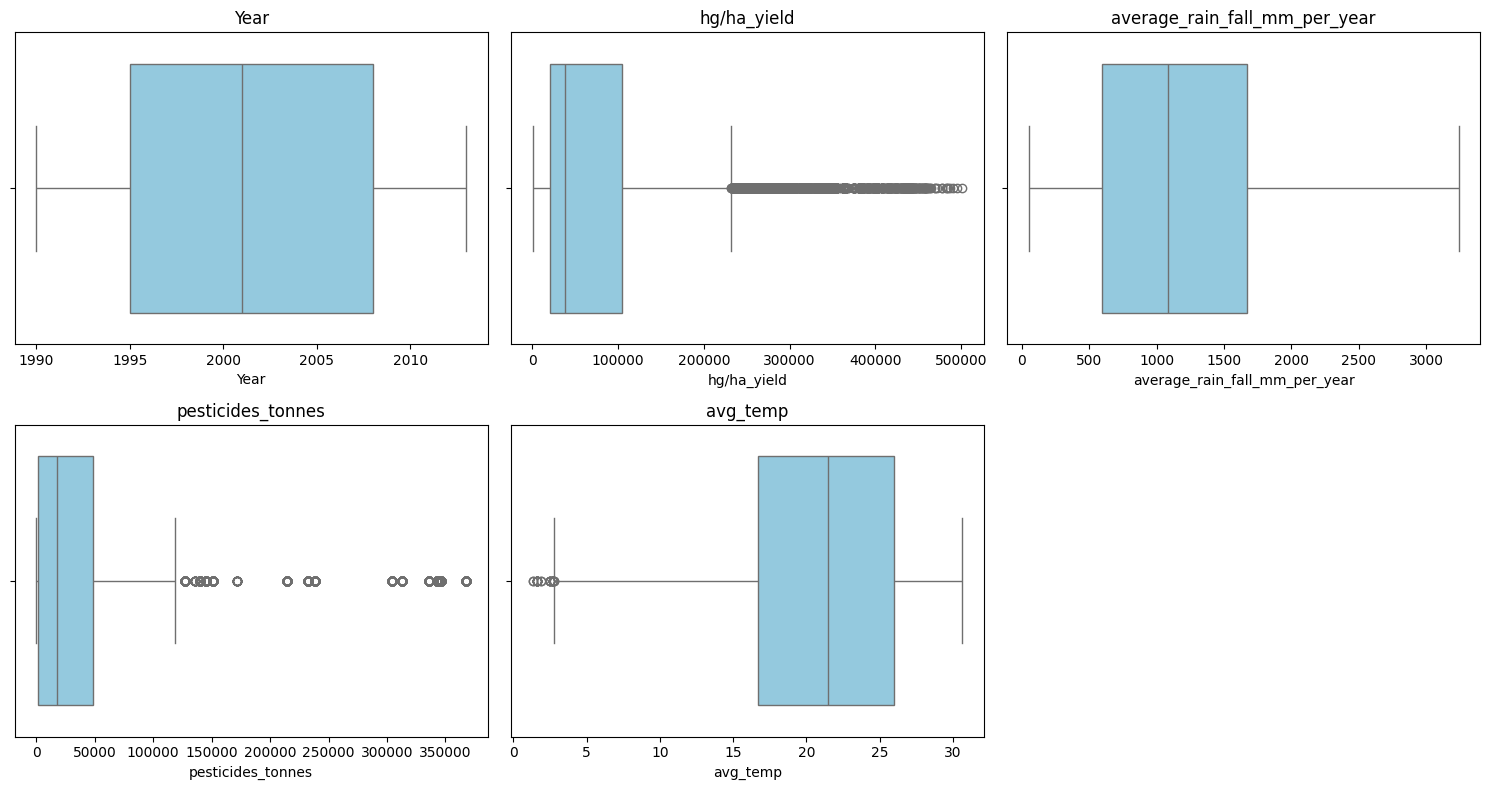

In [ ]:
numerical_visualisation(yield_df_2)

In [ ]:
categorical_analysis(yield_df_2)


=== ANALYSE DES VARIABLES CATÉGORIELLES ===

Variable : Area
  - Modalités distinctes : 101
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      India : 4048 (~ 14.3 %)
      Brazil : 2277 (~ 8.1 %)
      Mexico : 1472 (~ 5.2 %)
      Pakistan : 1449 (~ 5.1 %)
      Australia : 966 (~ 3.4 %)
      Japan : 966 (~ 3.4 %)
      Indonesia : 828 (~ 2.9 %)
      South Africa : 644 (~ 2.3 %)
      Turkey : 625 (~ 2.2 %)
      Ecuador : 621 (~ 2.2 %)
      Canada : 552 (~ 2.0 %)
      Spain : 483 (~ 1.7 %)
      Colombia : 414 (~ 1.5 %)
      Argentina : 368 (~ 1.3 %)
      Dominican Republic : 368 (~ 1.3 %)
      Egypt : 322 (~ 1.1 %)
      Morocco : 322 (~ 1.1 %)
      Italy : 322 (~ 1.1 %)
      Bangladesh : 294 (~ 1.0 %)
      Iraq : 276 (~ 1.0 %)
      Germany : 270 (~ 1.0 %)
      Kazakhstan : 252 (~ 0.9 %)
      Cameroon : 230 (~ 0.8 %)
      United Kingdom : 230 (~ 0.8 %)
      Kenya : 230 (~ 0.8 %)
      Chile : 230 (~ 0.8 %)
      Uganda : 207 (~ 0.7 %)
      Mali

In [ ]:
yield_df_2.columns

Index(['Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year',
       'pesticides_tonnes', 'avg_temp'],
      dtype='object')

In [ ]:
duplicates_data(yield_df_2, ['Area', 'Item', 'Year'])

Il y a 18949 doublons dans les données (colonnes ['Area', 'Item', 'Year']).


In [ ]:
# OK Vérifion ces doublons
yield_df_2[yield_df_2.duplicated(subset=['Area', 'Item', 'Year'], keep=False)].head(10)

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
377,Argentina,Cassava,1990,100000,591.0,26156.0,17.46
378,Argentina,Cassava,1990,100000,591.0,26156.0,17.67
379,Argentina,Maize,1990,34608,591.0,26156.0,17.46
380,Argentina,Maize,1990,34608,591.0,26156.0,17.67
381,Argentina,Potatoes,1990,202747,591.0,26156.0,17.46
382,Argentina,Potatoes,1990,202747,591.0,26156.0,17.67
383,Argentina,"Rice, paddy",1990,36709,591.0,26156.0,17.46
384,Argentina,"Rice, paddy",1990,36709,591.0,26156.0,17.67
385,Argentina,Sorghum,1990,28116,591.0,26156.0,17.46
386,Argentina,Sorghum,1990,28116,591.0,26156.0,17.67


In [ ]:
yield_df_2[yield_df_2.duplicated(subset=['Area', 'Item', 'Year'], keep=False)].tail(10)

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
27703,United Kingdom,Potatoes,2013,408993,1220.0,17673.46,8.76
27704,United Kingdom,Potatoes,2013,408993,1220.0,17673.46,9.57
27705,United Kingdom,Potatoes,2013,408993,1220.0,17673.46,9.57
27706,United Kingdom,Potatoes,2013,408993,1220.0,17673.46,8.39
27707,United Kingdom,Potatoes,2013,408993,1220.0,17673.46,9.91
27708,United Kingdom,Wheat,2013,73838,1220.0,17673.46,8.76
27709,United Kingdom,Wheat,2013,73838,1220.0,17673.46,9.57
27710,United Kingdom,Wheat,2013,73838,1220.0,17673.46,9.57
27711,United Kingdom,Wheat,2013,73838,1220.0,17673.46,8.39
27712,United Kingdom,Wheat,2013,73838,1220.0,17673.46,9.91


* Les doublons ne sont pas des copies strictes. Ils diffèrent uniquement sur la température (avg_temp). Solution :
  - Nous allons agréger la température puis fusionné avec le reste des données
  - Puis supprimé les doublons restant

In [ ]:
# Extraction de la température
temp_raw = yield_df_2[["Area", "Year", "avg_temp"]]

#agrégons par area et year
temp_clean = temp_raw.groupby(["Area", "Year"], as_index=False).agg({
    "avg_temp": "mean"
})
temp_clean.head()

,Area,Year,avg_temp
0,Albania,1990,16.37
1,Albania,1991,15.36
2,Albania,1992,16.06
3,Albania,1993,16.05
4,Albania,1994,16.96


In [ ]:
# on supprimme l'ancien avg_temp
yield_df_2 = yield_df_2.drop(columns=["avg_temp"])

#fuisons
final_yield = yield_df_2.merge(temp_clean, on=["Area", "Year"], how="left")

In [ ]:
final_yield[final_yield.duplicated(subset=['Area', 'Item', 'Year'], keep=False)].tail(10)

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
27703,United Kingdom,Potatoes,2013,408993,1220.0,17673.46,9.24
27704,United Kingdom,Potatoes,2013,408993,1220.0,17673.46,9.24
27705,United Kingdom,Potatoes,2013,408993,1220.0,17673.46,9.24
27706,United Kingdom,Potatoes,2013,408993,1220.0,17673.46,9.24
27707,United Kingdom,Potatoes,2013,408993,1220.0,17673.46,9.24
27708,United Kingdom,Wheat,2013,73838,1220.0,17673.46,9.24
27709,United Kingdom,Wheat,2013,73838,1220.0,17673.46,9.24
27710,United Kingdom,Wheat,2013,73838,1220.0,17673.46,9.24
27711,United Kingdom,Wheat,2013,73838,1220.0,17673.46,9.24
27712,United Kingdom,Wheat,2013,73838,1220.0,17673.46,9.24


In [ ]:
final_yield = final_yield.drop_duplicates(subset=["Area", "Item", "Year"])

In [ ]:
duplicates_data(final_yield, ['Area', 'Item', 'Year'])

Il n'y a pas de doublons dans les données.


In [ ]:
# Etude des outiliers
out_yield = detect_outliers(final_yield,2)


=== Détection des valeurs aberrantes (méthode IQR) avec un seuil(2) ===

                               nb_outliers  lower_bound  upper_bound
Year                                   0.0      1969.00      2034.00
hg/ha_yield                          507.0   -140304.50    255456.75
average_rain_fall_mm_per_year          0.0     -1478.00      3737.00
pesticides_tonnes                   1496.0    -25876.85     39476.60
avg_temp                               0.0        -4.55        46.00

Nombre total de lignes contenant au moins un outlier : 1893


In [ ]:
out_yield.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
96,Albania,Potatoes,2013,260110,1485.0,982.32,17.41
194,Algeria,Potatoes,2010,270526,89.0,1295.88,17.59
199,Algeria,Potatoes,2011,292806,89.0,13861.76,17.79
204,Algeria,Potatoes,2012,304291,89.0,17379.76,17.91
209,Algeria,Potatoes,2013,303218,89.0,17278.65,17.65


In [ ]:
# Voyons les pays les plus présents
out_yield["Area"].value_counts()

,count
Area,
Brazil,207
Japan,161
Italy,161
India,142
France,138
Argentina,137
Colombia,135
Mexico,72
Thailand,70


In [ ]:
# les type de cultures
out_yield['Item'].value_counts()

,count
Item,
Potatoes,530
Maize,212
Wheat,205
Soybeans,205
"Rice, paddy",196
Sweet potatoes,167
Sorghum,166
Cassava,106
Yams,61


In [ ]:
# Appliquons du log-transformation sur nos deux variables
final_yield['hg/ha_yield_log'] = np.log1p(final_yield['hg/ha_yield'])
final_yield["pesticides_tonnes_log"] = np.log1p(final_yield['pesticides_tonnes'])

In [ ]:
final_yield.drop(columns=['hg/ha_yield', 'pesticides_tonnes'], inplace=True)


=== Affichage des boxplots (5 variables) ===



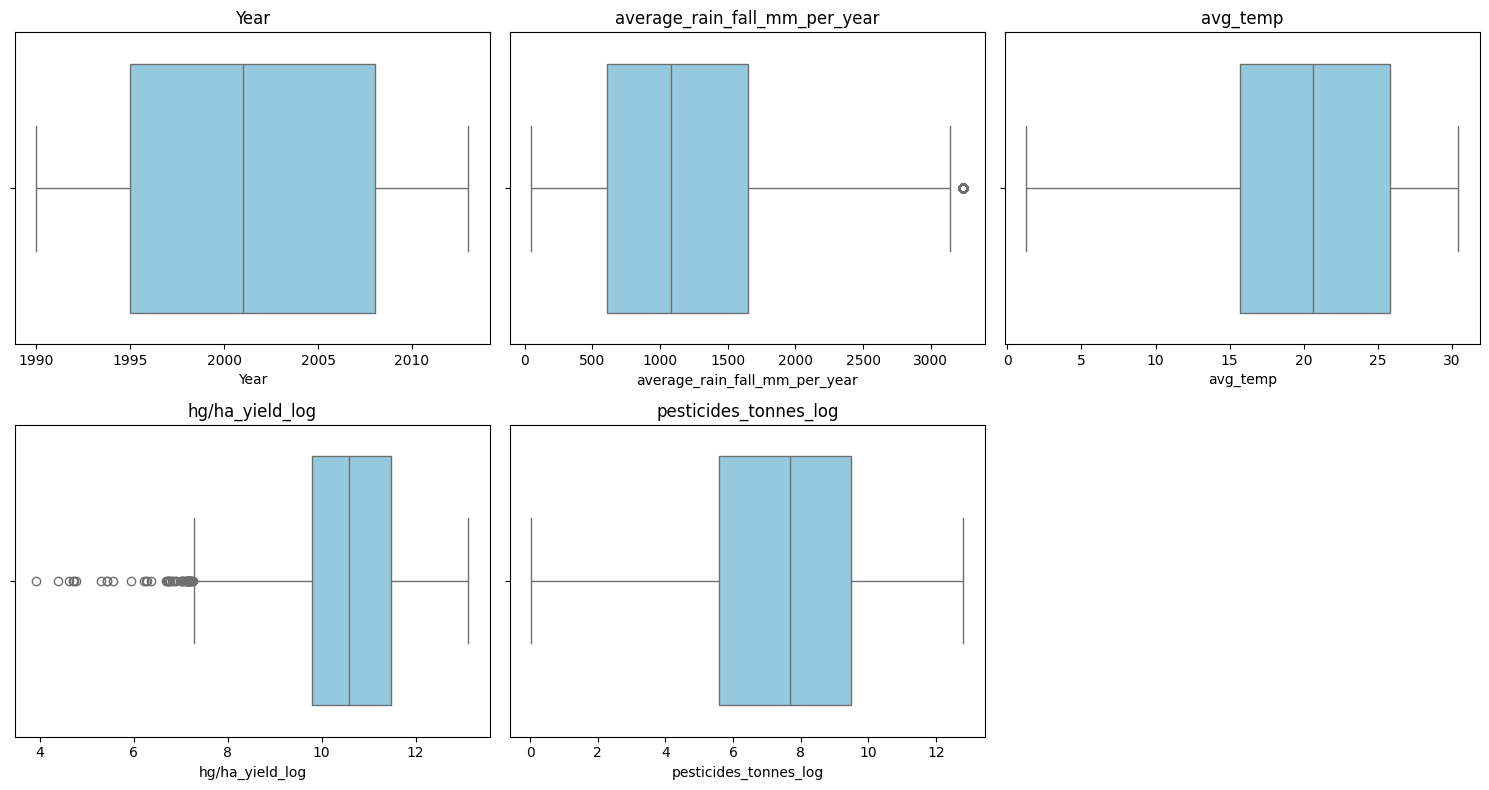

In [ ]:
numerical_visualisation(final_yield)

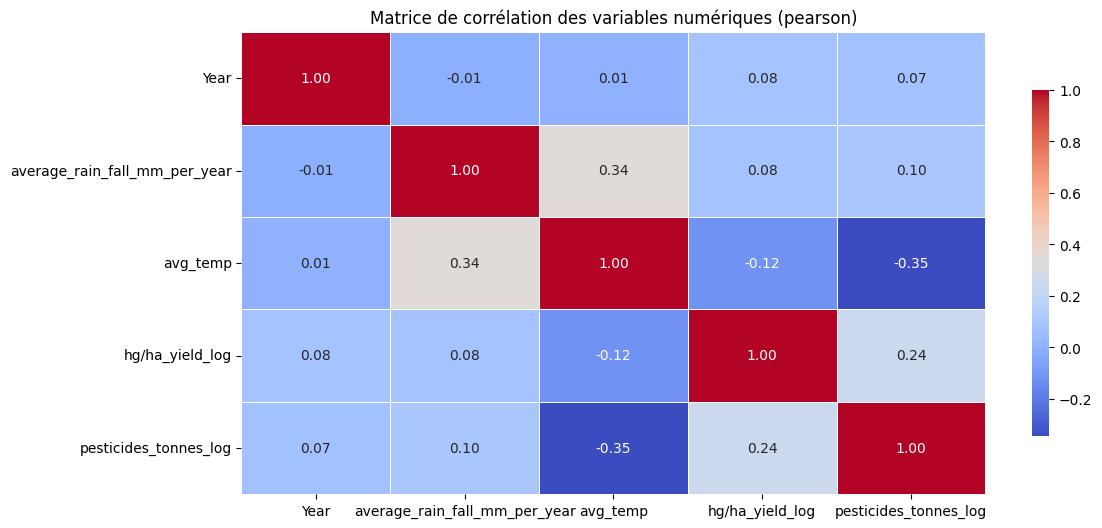

In [ ]:
correlation_graph(final_yield, 'pearson')

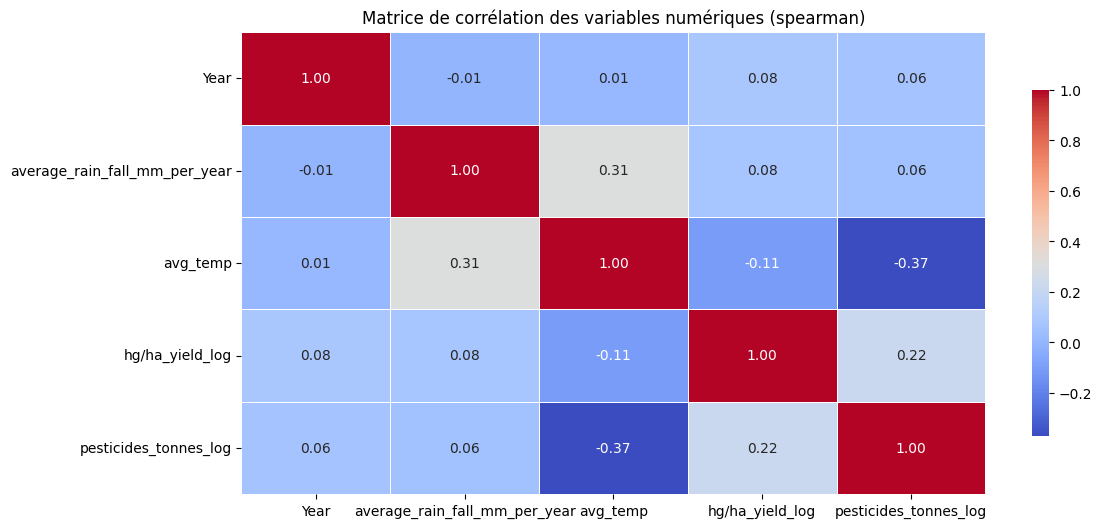

In [ ]:
correlation_graph(final_yield, 'spearman')

In [ ]:
chi2_study(final_yield)


=== Analyse Chi² des variables catégorielles ===

Area vs Item
Chi2 = 7681.08, ddl = 900, p-value = 0.000000
Forte dépendance entre les deux
------------------------------------------------------------


In [ ]:
final_yield.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13130 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           13130 non-null  object 
 1   Item                           13130 non-null  object 
 2   Year                           13130 non-null  int64  
 3   average_rain_fall_mm_per_year  13130 non-null  float64
 4   avg_temp                       13130 non-null  float64
 5   hg/ha_yield_log                13130 non-null  float64
 6   pesticides_tonnes_log          13130 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 820.6+ KB


## FUSION

----

- Après toutes ces analyses je pense que Le dernier fichier (13130 lignes) est déjà une fusion du fichier FAO + pluie + pesticides + température. Car si nous observons bien :     
  - **Pesticides -> correspondance dans final_yield :** Area -> Area, Year -> Year, Value_log -> pesticides_tonnes_log
  - **Rainfall :** Area -> Area, Year -> Year, average_rain_fall_mm_per_year -> average_rain_fall_mm_per_year
  - **Temperature :** country -> Area, year -> year, avg_temp -> avg_temp
  - **Yield :** Area -> Area, Item -> Item, Year -> Year, Value_log -> hg/ha_yield_log

In [ ]:
print(temp_df.shape)
print(rainfall_df.shape)
print(pesticides_df.shape)
print(yield_df_1.shape)
print(final_yield.shape)

(28514, 3)
(5952, 3)
(4349, 3)
(56717, 4)
(13130, 7)


In [ ]:
final_yield.head()

,Area,Item,Year,average_rain_fall_mm_per_year,avg_temp,hg/ha_yield_log,pesticides_tonnes_log
0,Albania,Maize,1990,1485.0,16.37,10.508186,4.804021
1,Albania,Potatoes,1990,1485.0,16.37,11.107480,4.804021
2,Albania,"Rice, paddy",1990,1485.0,16.37,10.057667,4.804021
3,Albania,Sorghum,1990,1485.0,16.37,9.433564,4.804021
4,Albania,Soybeans,1990,1485.0,16.37,8.853808,4.804021


In [ ]:
crop_yield_df.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


* **Conclusion de Fusion :** Je ne peux PAS fusionner ces deux fichiers ligne par ligne car :
  
  - Ils n’ont aucune clé commune
  - Ils ne représentent pas les mêmes pays, cultures, années ou unités
  - Une fusion produirait un dataset faux
  - Je peux les utiliser séparément
  - Je peux comparer leurs distributions
  - Je peux entraîner des modèles séparés
  - Je peux faire un mapping conceptuel (pas une fusion)

In [ ]:
# Je vais fuisionné les 4 fichier pour lui comparer avec final_yield
# renommons les colonne value en yield
yield_df_1 = yield_df_1.rename(columns={"Value_log": "hg/ha_yield_log"})

In [ ]:
# Renommons contry en Area et year en Year
temp_df = temp_df.rename(columns={
    "country": "Area",
    "year": "Year"
})

In [ ]:
rainfall_df = rainfall_df.rename(columns={' Area': 'Area'})

In [ ]:
# Renommons value en pesticides_tonnes
pesticides_df = pesticides_df.rename(columns={"Value_log": "pesticides_tonnes_log"})

In [ ]:
yield_df_1.shape, rainfall_df.shape

((56717, 4), (5952, 3))

In [ ]:
# yield + rainfall
df = yield_df_1.merge(rainfall_df, on =["Area", "Year"], how="left")

In [ ]:
df.shape, pesticides_df.shape

((56717, 5), (4349, 3))

In [ ]:
# + pesticides
df = df.merge(pesticides_df, on=["Area", "Year"], how="left")

In [ ]:
df.shape, temp_df.shape

((56717, 6), (28514, 3))

In [ ]:
# + temperature
df = df.merge(temp_df, on=['Area', 'Year'], how='left')

In [ ]:
df.columns

Index(['Area', 'Item', 'Year', 'hg/ha_yield_log',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes_log', 'avg_temp'],
      dtype='object')

In [ ]:
final_yield.columns

Index(['Area', 'Item', 'Year', 'average_rain_fall_mm_per_year', 'avg_temp',
       'hg/ha_yield_log', 'pesticides_tonnes_log'],
      dtype='object')

In [ ]:
df.dropna().shape, final_yield.shape

((13136, 7), (13130, 7))

In [ ]:
# Analysons ces deux jeu de données
numerical_analysis(df.dropna())


=== ANALYSE DES VARIABLES NUMÉRIQUES ===

Variable : Year
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 1990
  - Max : 2013
  - Moyenne : 2001.62
  - Médiane : 2001.00
  - Écart-type : 7.04
--------------------------------------------------
Variable : hg/ha_yield_log
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 3.9318256327243257
  - Max : 13.125185391773492
  - Moyenne : 10.60
  - Médiane : 10.58
  - Écart-type : 1.13
--------------------------------------------------
Variable : average_rain_fall_mm_per_year
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 51.0
  - Max : 3240.0
  - Moyenne : 1157.30
  - Médiane : 1083.00
  - Écart-type : 743.46
--------------------------------------------------
Variable : pesticides_tonnes_log
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 0.039220713153281295
  - Max : 12.815237493274344
  - Moyenne : 7.47
  - Médiane : 7.68
  - Écart-type : 2.58
--------------------------------------------------
Variable : avg_temp
  - Valeurs manquantes : 0 (0.0 %)
  - M

In [ ]:
numerical_analysis(final_yield)


=== ANALYSE DES VARIABLES NUMÉRIQUES ===

Variable : Year
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 1990
  - Max : 2013
  - Moyenne : 2001.62
  - Médiane : 2001.00
  - Écart-type : 7.03
--------------------------------------------------
Variable : average_rain_fall_mm_per_year
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 51.0
  - Max : 3240.0
  - Moyenne : 1157.24
  - Médiane : 1083.00
  - Écart-type : 743.62
--------------------------------------------------
Variable : avg_temp
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 1.3
  - Max : 30.419999999999998
  - Moyenne : 19.84
  - Médiane : 20.62
  - Écart-type : 6.66
--------------------------------------------------
Variable : hg/ha_yield_log
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 3.9318256327243257
  - Max : 13.125185391773492
  - Moyenne : 10.60
  - Médiane : 10.59
  - Écart-type : 1.13
--------------------------------------------------
Variable : pesticides_tonnes_log
  - Valeurs manquantes : 0 (0.0 %)
  - Min : 0.03922071

In [ ]:
categorical_analysis(df.dropna())


=== ANALYSE DES VARIABLES CATÉGORIELLES ===

Variable : Area
  - Modalités distinctes : 101
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      Cameroon : 230 (~ 1.8 %)
      Kenya : 230 (~ 1.8 %)
      Colombia : 207 (~ 1.6 %)
      Brazil : 207 (~ 1.6 %)
      Burundi : 207 (~ 1.6 %)
      Peru : 207 (~ 1.6 %)
      Rwanda : 207 (~ 1.6 %)
      Mali : 207 (~ 1.6 %)
      Uganda : 207 (~ 1.6 %)
      Ecuador : 207 (~ 1.6 %)
      Guatemala : 204 (~ 1.6 %)
      Honduras : 204 (~ 1.6 %)
      El Salvador : 184 (~ 1.4 %)
      India : 184 (~ 1.4 %)
      Madagascar : 184 (~ 1.4 %)
      Dominican Republic : 184 (~ 1.4 %)
      Burkina Faso : 184 (~ 1.4 %)
      Argentina : 184 (~ 1.4 %)
      Zimbabwe : 184 (~ 1.4 %)
      Mexico : 184 (~ 1.4 %)
      Sri Lanka : 184 (~ 1.4 %)
      Zambia : 184 (~ 1.4 %)
      Haiti : 184 (~ 1.4 %)
      Nicaragua : 183 (~ 1.4 %)
      Malawi : 171 (~ 1.3 %)
      Guinea : 171 (~ 1.3 %)
      Angola : 164 (~ 1.2 %)
      Egypt : 16

In [ ]:
categorical_analysis(final_yield)


=== ANALYSE DES VARIABLES CATÉGORIELLES ===

Variable : Area
  - Modalités distinctes : 101
  - Valeurs manquantes : 0 (0.0 %)
  - Fréquences des modalités :
      Cameroon : 230 (~ 1.8 %)
      Kenya : 230 (~ 1.8 %)
      Colombia : 207 (~ 1.6 %)
      Brazil : 207 (~ 1.6 %)
      Burundi : 207 (~ 1.6 %)
      Peru : 207 (~ 1.6 %)
      Rwanda : 207 (~ 1.6 %)
      Mali : 207 (~ 1.6 %)
      Uganda : 207 (~ 1.6 %)
      Ecuador : 207 (~ 1.6 %)
      Guatemala : 204 (~ 1.6 %)
      Honduras : 204 (~ 1.6 %)
      El Salvador : 184 (~ 1.4 %)
      India : 184 (~ 1.4 %)
      Madagascar : 184 (~ 1.4 %)
      Dominican Republic : 184 (~ 1.4 %)
      Burkina Faso : 184 (~ 1.4 %)
      Argentina : 184 (~ 1.4 %)
      Zimbabwe : 184 (~ 1.4 %)
      Mexico : 184 (~ 1.4 %)
      Sri Lanka : 184 (~ 1.4 %)
      Zambia : 184 (~ 1.4 %)
      Haiti : 184 (~ 1.4 %)
      Nicaragua : 183 (~ 1.4 %)
      Malawi : 171 (~ 1.3 %)
      Guinea : 171 (~ 1.3 %)
      Angola : 164 (~ 1.2 %)
      Egypt : 16

* Conclusion :
  - Après fusion brute + dropna + nettoyage, notre dataset reconstruit est identique à ton dataset final_yield car
  - 101 pays dans les deux datasets
  - 10 cultures dans les deux datasets
  - même moyenne, même min/max, médianes et écarts-types

In [ ]:
# sauvégarde du fichier qui nous servira pour la modelisaton
os.makedirs("../data/train_data", exist_ok=True)

In [ ]:
final_yield.to_csv("../data/train_data/yield_data.csv", index=False)